In [1]:
# Import libraries
import os
import sys
import requests
import sqlalchemy
from sqlalchemy.sql import text

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from utils.database import get_db
import utils.models as models

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

# Create connection to Database and extraction of required data

In [2]:
# create connection to the database
db = get_db()

In [3]:
# Define requested ticker ID:
ticker_id = 32

In [4]:
# set the presentation format of float numbers within the dataframe

pd.set_option('display.float_format', lambda x: '%.3f' % x)


### Fetch "daily multipliers" table from database

In [5]:
query = db.query(models.FullDailyMultipliers)
df_daily_multipliers = pd.read_sql(query.statement, query.session.bind)
df_daily_multipliers.head()
# len(df_daily_multipliers.index)
df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
73,74,2013-03-31,1,NaN,NaN,NaN,NaN,13.372
138,139,2013-06-30,1,NaN,NaN,NaN,NaN,4.769
1023,1024,2016-12-31,1,NaN,NaN,NaN,NaN,1.616
1212,1213,2017-09-30,1,NaN,NaN,NaN,NaN,2.706
1276,1277,2017-12-31,1,NaN,NaN,NaN,NaN,-0.474
...,...,...,...,...,...,...,...,...
1214116,1214117,2018-03-31,503,NaN,NaN,NaN,NaN,0.954
1214181,1214182,2018-06-30,503,NaN,NaN,NaN,NaN,0.738
1214245,1214246,2018-09-30,503,NaN,NaN,NaN,NaN,2.227
1214370,1214371,2019-03-31,503,NaN,NaN,NaN,NaN,-3.510


In [6]:
# Choose the stock_id we want to check (ticker_id)
daily_multipliers = df_daily_multipliers.loc[df_daily_multipliers['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
daily_multipliers = daily_multipliers.query('"2013-01-01" < date').copy().reset_index(drop=True)


daily_multipliers.head()
# df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
0,73720,2013-01-02,32,21181100000.000,39640100000.000,16.788,1.390,-0.182
1,73721,2013-01-03,32,21166600000.000,39625600000.000,16.777,1.389,-0.182
2,73722,2013-01-04,32,21132600000.000,39591600000.000,16.750,1.387,-0.182
3,73723,2013-01-07,32,21045300000.000,39504300000.000,16.681,1.381,-0.181
4,73724,2013-01-08,32,20938500000.000,39397500000.000,16.596,1.374,-0.180


### Fetch "end of day prices" table from database

In [7]:

query = db.query(models.EndOfDayPrices)
df_end_of_day_prices = pd.read_sql(query.statement, query.session.bind)
df_end_of_day_prices.head()

# len(df_end_of_day_prices.head().index)


,id,stock_id,date,close_price
0,1,1,2012-01-03,83.490
1,2,1,2012-01-04,84.180
2,3,1,2012-01-05,83.800
3,4,1,2012-01-06,83.370
4,5,1,2012-01-09,83.870


### Select specific stock from end of day prices table (Apple Stock)

In [8]:
# Choose the stock_id we want to check (ticker_id)
end_of_day_prices = df_end_of_day_prices.loc[df_end_of_day_prices['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
end_of_day_prices = end_of_day_prices.query('"2013-01-01" < date').copy().reset_index(drop=True)


end_of_day_prices.head()
end_of_day_prices[end_of_day_prices.isna().any(axis=1)]

,id,stock_id,date,close_price


### Fetch "pfree cash flow multiplier" table from database

In [9]:
# fetch the end of day prices table from database

query = db.query(models.PFreeCashFlowMultiplier)
df_pfree_cash_flow = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
pfree_cash_flow = df_pfree_cash_flow.loc[df_pfree_cash_flow['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
pfree_cash_flow = pfree_cash_flow.query('"2013-01-01" < date').copy().reset_index(drop=True)


pfree_cash_flow.shape
pfree_cash_flow[pfree_cash_flow.isna().any(axis=1)]


,id,stock_id,date,year,quarter,pfree_cash_flow_ratio
2267,87613,32,2022-01-03,2022,1,NaN
2268,87614,32,2022-01-04,2022,1,NaN
2269,87615,32,2022-01-05,2022,1,NaN
2270,87616,32,2022-01-06,2022,1,NaN
2271,87617,32,2022-01-07,2022,1,NaN
...,...,...,...,...,...,...
2490,87836,32,2022-11-21,2022,4,NaN
2491,87837,32,2022-11-22,2022,4,NaN
2492,87838,32,2022-11-23,2022,4,NaN
2493,87839,32,2022-11-25,2022,4,NaN


### Fetch "graham number" table from database

In [10]:
# fetch the end of day prices table from database

query = db.query(models.GrahamNumber)
df_graham_number = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
graham_number = df_graham_number.loc[df_graham_number['stock_id'] == ticker_id]

# filter year =< 2012
graham_number = graham_number.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
graham_number.shape

graham_number[graham_number.isna().any(axis=1)]


,id,stock_id,year,quarter,graham_value
0,1264,32,2022,1,NaN
1,1265,32,2022,2,NaN
2,1266,32,2022,3,NaN


### Fetch "overview data" table from database

In [11]:
# fetch the overview data table from database

overview = models.QuarterlyOverview
query = db.query(overview.stock_id, overview.year, overview.quarter, overview.currentRatio )
df_overview_data = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
overview_data = df_overview_data.loc[df_overview_data['stock_id'] == ticker_id]

# filter year =< 2012
overview_data = overview_data.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
# overview_data.shape

overview_data

overview_data[overview_data.isna().any(axis=1)]

,stock_id,year,quarter,currentRatio
4,32,2021,0,NaN
9,32,2020,0,NaN
14,32,2019,0,NaN
19,32,2018,0,NaN
24,32,2017,0,NaN
29,32,2016,0,NaN
34,32,2015,0,NaN
39,32,2014,0,NaN
44,32,2013,0,NaN


# Preprocessing of the data

# Join all five dataframes

In [12]:
# First, combine the two dataframes: "end of day prices" and "daily multipliers" into one joined dataframe (using outer join to maintain all rows)
joined_dataframe = pd.merge(end_of_day_prices, daily_multipliers, on='date', how='inner')

# Create 2 new columns for "date_plus_3m" & "market_cap_plus_3m"
day_gap = 60
date_plus_3m = joined_dataframe.loc[day_gap:,'date'].values
market_cap_plus_3m = joined_dataframe.loc[day_gap:,'market_cap'].values


joined_dataframe.drop(joined_dataframe.tail(day_gap).index, inplace = True)
joined_dataframe['date_plus_3m'] = date_plus_3m
joined_dataframe['market_cap_plus_3m'] = market_cap_plus_3m

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices = joined_dataframe

multiplier_with_closing_prices

# Check for Nan values in joined dataframe
multiplier_with_closing_prices[multiplier_with_closing_prices.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m


In [13]:
# Second, join the two dataframes: "multiplier_with_closing_prices" and "pfree_cash_flow" into one joined dataframe (using outer join to maintain all rows)

joined_dataframe = pd.merge(multiplier_with_closing_prices, pfree_cash_flow, on='date', how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Convert "date" column's type from object to datetime and "stock id" to int
joined_dataframe['date'] = pd.to_datetime(joined_dataframe['date'])
joined_dataframe['stock_id'] = joined_dataframe['stock_id'].astype('int')

# Handle Nan values that were formed due to the left join of the two dataframes
joined_dataframe["pfree_cash_flow_ratio"] = joined_dataframe["pfree_cash_flow_ratio"].interpolate(axis=0, limit_area='inside', limit=5)

joined_dataframe["year"] = joined_dataframe["date"].dt.year
joined_dataframe['quarter'] = joined_dataframe['date'].dt.quarter

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices_and_cash_flow = joined_dataframe

# multiplier_with_closing_prices_and_cash_flow

# multiplier_with_closing_prices_and_cash_flow.head()
multiplier_with_closing_prices_and_cash_flow[multiplier_with_closing_prices_and_cash_flow.isna().any(axis=1)]



,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio
2267,2267,32,2022-01-03,88.610,44628600000.000,80836100000.000,17.793,1.964,0.824,2022-03-30,50128800000.000,2022,1,NaN
2268,2268,32,2022-01-04,88.650,44648700000.000,80856200000.000,17.801,1.965,0.824,2022-03-31,50305200000.000,2022,1,NaN
2269,2269,32,2022-01-05,89.470,45061700000.000,81269200000.000,17.966,1.983,0.832,2022-04-01,51182600000.000,2022,1,NaN
2270,2270,32,2022-01-06,89.180,44915700000.000,81123200000.000,17.908,1.977,0.829,2022-04-04,50748900000.000,2022,1,NaN
2271,2271,32,2022-01-07,90.800,45731600000.000,81939100000.000,18.233,2.013,0.844,2022-04-05,51081700000.000,2022,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,32,2022-08-26,101.820,52308400000.000,89920300000.000,20.004,2.146,-1.657,2022-11-21,47866400000.000,2022,3,NaN
2431,2431,32,2022-08-29,102.930,52878600000.000,90490500000.000,20.222,2.170,-1.676,2022-11-22,48154200000.000,2022,3,NaN
2432,2432,32,2022-08-30,101.340,52061800000.000,89673700000.000,19.910,2.136,-1.650,2022-11-23,48883900000.000,2022,3,NaN
2433,2433,32,2022-08-31,100.200,51476100000.000,89088000000.000,19.686,2.112,-1.631,2022-11-25,49058600000.000,2022,3,NaN


In [14]:
# Next, merge the dataframe - "graham number", which has quarterly data with the previously joined dataframe,

joined_dataframe = pd.merge(multiplier_with_closing_prices_and_cash_flow, graham_number, on=['year', 'quarter'], how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
four_joined_dataframes = joined_dataframe

# four_joined_dataframes.head()

four_joined_dataframes[four_joined_dataframes.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value
2267,2267,32,2022-01-03,88.610,44628600000.000,80836100000.000,17.793,1.964,0.824,2022-03-30,50128800000.000,2022,1,NaN,NaN
2268,2268,32,2022-01-04,88.650,44648700000.000,80856200000.000,17.801,1.965,0.824,2022-03-31,50305200000.000,2022,1,NaN,NaN
2269,2269,32,2022-01-05,89.470,45061700000.000,81269200000.000,17.966,1.983,0.832,2022-04-01,51182600000.000,2022,1,NaN,NaN
2270,2270,32,2022-01-06,89.180,44915700000.000,81123200000.000,17.908,1.977,0.829,2022-04-04,50748900000.000,2022,1,NaN,NaN
2271,2271,32,2022-01-07,90.800,45731600000.000,81939100000.000,18.233,2.013,0.844,2022-04-05,51081700000.000,2022,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,32,2022-08-26,101.820,52308400000.000,89920300000.000,20.004,2.146,-1.657,2022-11-21,47866400000.000,2022,3,NaN,NaN
2431,2431,32,2022-08-29,102.930,52878600000.000,90490500000.000,20.222,2.170,-1.676,2022-11-22,48154200000.000,2022,3,NaN,NaN
2432,2432,32,2022-08-30,101.340,52061800000.000,89673700000.000,19.910,2.136,-1.650,2022-11-23,48883900000.000,2022,3,NaN,NaN
2433,2433,32,2022-08-31,100.200,51476100000.000,89088000000.000,19.686,2.112,-1.631,2022-11-25,49058600000.000,2022,3,NaN,NaN


In [15]:
# Finally, merge the remaining dataframe - "overview", which has quarterly data with the previously joined dataframe,


joined_dataframe = pd.merge(four_joined_dataframes, overview_data, on=['stock_id', 'year', 'quarter'], how='left')

# Rename dataframe for clarity purposes
final_joined_dataframe = joined_dataframe

# final_joined_dataframe.head()
final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

# final_joined_dataframe

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio
2267,2267,32,2022-01-03,88.610,44628600000.000,80836100000.000,17.793,1.964,0.824,2022-03-30,50128800000.000,2022,1,NaN,NaN,0.609
2268,2268,32,2022-01-04,88.650,44648700000.000,80856200000.000,17.801,1.965,0.824,2022-03-31,50305200000.000,2022,1,NaN,NaN,0.609
2269,2269,32,2022-01-05,89.470,45061700000.000,81269200000.000,17.966,1.983,0.832,2022-04-01,51182600000.000,2022,1,NaN,NaN,0.609
2270,2270,32,2022-01-06,89.180,44915700000.000,81123200000.000,17.908,1.977,0.829,2022-04-04,50748900000.000,2022,1,NaN,NaN,0.609
2271,2271,32,2022-01-07,90.800,45731600000.000,81939100000.000,18.233,2.013,0.844,2022-04-05,51081700000.000,2022,1,NaN,NaN,0.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,32,2022-08-26,101.820,52308400000.000,89920300000.000,20.004,2.146,-1.657,2022-11-21,47866400000.000,2022,3,NaN,NaN,0.787
2431,2431,32,2022-08-29,102.930,52878600000.000,90490500000.000,20.222,2.170,-1.676,2022-11-22,48154200000.000,2022,3,NaN,NaN,0.787
2432,2432,32,2022-08-30,101.340,52061800000.000,89673700000.000,19.910,2.136,-1.650,2022-11-23,48883900000.000,2022,3,NaN,NaN,0.787
2433,2433,32,2022-08-31,100.200,51476100000.000,89088000000.000,19.686,2.112,-1.631,2022-11-25,49058600000.000,2022,3,NaN,NaN,0.787


In [16]:
# create a new column - "diff_in_market_cap_perc" where:
# 1. calculates the change in market cap value 3 months apart and presents the difference in percentage

col1 = final_joined_dataframe['market_cap']
col2 = final_joined_dataframe['market_cap_plus_3m']

final_joined_dataframe['diff_in_mc'] = col2.sub(col1, axis=0)
final_joined_dataframe['diff_in_mc_perc'] = ((col2.sub(col1, axis=0)).div(col1)).mul(100)

# final_joined_dataframe.shape
final_joined_dataframe.head(200)

# final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc
0,0,32,2013-01-02,43.650,21181100000.000,39640100000.000,16.788,1.390,-0.182,2013-04-01,23554900000.000,2013,1,43.326,46.603,0.712,2373800000.000,11.207
1,1,32,2013-01-03,43.620,21166600000.000,39625600000.000,16.777,1.389,-0.182,2013-04-02,23477200000.000,2013,1,43.296,46.603,0.712,2310600000.000,10.916
2,2,32,2013-01-04,43.550,21132600000.000,39591600000.000,16.750,1.387,-0.182,2013-04-03,23360600000.000,2013,1,43.227,46.603,0.712,2228000000.000,10.543
3,3,32,2013-01-07,43.370,21045300000.000,39504300000.000,16.681,1.381,-0.181,2013-04-04,23632600000.000,2013,1,43.048,46.603,0.712,2587300000.000,12.294
4,4,32,2013-01-08,43.150,20938500000.000,39397500000.000,16.596,1.374,-0.180,2013-04-05,23656900000.000,2013,1,42.830,46.603,0.712,2718400000.000,12.983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,32,2013-10-10,44.140,21486100000.000,40125100000.000,18.546,1.363,-1.686,2014-01-07,22600500000.000,2013,4,43.959,47.518,0.705,1114400000.000,5.187
196,196,32,2013-10-11,44.270,21549400000.000,40188400000.000,18.601,1.367,-1.691,2014-01-08,22464100000.000,2013,4,44.088,47.518,0.705,914700000.000,4.245
197,197,32,2013-10-14,44.070,21452100000.000,40091100000.000,18.517,1.361,-1.683,2014-01-09,22551800000.000,2013,4,43.889,47.518,0.705,1099700000.000,5.126
198,198,32,2013-10-15,43.480,21164900000.000,39803900000.000,18.269,1.343,-1.661,2014-01-10,23000100000.000,2013,4,43.301,47.518,0.705,1835200000.000,8.671


# 1. Optimizing the random forest model

In [17]:
# Define requested model and label thresholds:

label_threshold_lst = [1, 5, 10, 15, 20]

model_threshold_lst = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [18]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'
final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# Split the data to 60% train, 20% validation, 20% test
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


# Set the x (=features)
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']

# Split X to train and test
X_train, X_validation = train[X_Cols], validation[X_Cols]


In [19]:
train.shape

(1069, 18)

In [20]:
validation.shape

(357, 18)

In [21]:
test.shape

(357, 18)

In [22]:
# Model optimization using ParameterGrid() - ~percentage~ of profit

profit_with_params_dict = {}
# y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves

rf_clf_full_params = {
                'n_estimators':[51,101,151], # The number of trees in the forest
                'criterion':["gini", "entropy"], # The function to measure the quality of a split.
                'max_depth':[5, 7, 9, 11],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                'max_features':[3, 5, 7, 8], # The number of features to consider when looking for the best split results
                'random_state':[711]
                 }


# classifier = RandomForestClassifier
params = rf_clf_full_params
all_rf_params_permutations = list(ParameterGrid(params))
# print(len(list(ParameterGrid(params))))
# print(list(ParameterGrid(params)))

# Loop through different model parameters in order to find the optimized set of parameters for the requested stock, testing on a validation set:
for label_thresh in tqdm(label_threshold_lst, desc="label threshold"):
    # final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)    # create the label column  according to the first two parameters - label and model threshold
    train['label'] = (train["diff_in_mc_perc"] > label_thresh).astype(int)
    validation['label'] = (validation["diff_in_mc_perc"] > label_thresh).astype(int)
    Y_Cols = ['label']
    y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()  # this changes according to the tested label threshold, therefor inserted into the for loop
    for model_thresh in tqdm(model_threshold_lst, desc="model threshold"):
        for params in tqdm(all_rf_params_permutations, desc="model params"):
            rand_frst_clf = RandomForestClassifier(**params)  # run through the different classifier's parameters options
            rand_frst_clf.fit(X_train, y_train)   # fit (train) the data to the model
            y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1] # Make predictions (validation)
            y_pred = y_pred_proba > model_thresh
            validation['prediction'] = y_pred.astype(int)
            validation['profit_percentage'] = validation['diff_in_mc_perc'] * validation['prediction']
            profit_perc_sum = round(validation['profit_percentage'].sum(), 3)
            profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
            print('profit_perc_sum', profit_perc_sum, 'profit_perc_mean', profit_perc_mean, 'denominator', validation[validation['prediction']==1].shape[0])
            profit_with_params_dict[profit_perc_mean] = [label_thresh, model_thresh, params]

profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
max_profit_perc_in_sorted_dict = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:5]}

print(max_profit_perc_in_sorted_dict)

model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.78it/s]

profit_perc_sum 446.197 profit_perc_mean 3.628 denominator 123




model params:   2%|▏         | 2/96 [00:00<00:20,  4.53it/s]

profit_perc_sum 816.762 profit_perc_mean 4.368 denominator 187




model params:   3%|▎         | 3/96 [00:00<00:30,  3.09it/s]

profit_perc_sum 773.458 profit_perc_mean 4.716 denominator 164




model params:   4%|▍         | 4/96 [00:01<00:24,  3.68it/s]

profit_perc_sum 839.268 profit_perc_mean 3.304 denominator 254




model params:   5%|▌         | 5/96 [00:01<00:28,  3.18it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:   6%|▋         | 6/96 [00:01<00:35,  2.52it/s]

profit_perc_sum 987.166 profit_perc_mean 3.358 denominator 294




model params:   7%|▋         | 7/96 [00:02<00:30,  2.90it/s]

profit_perc_sum 393.114 profit_perc_mean 1.101 denominator 357




model params:   8%|▊         | 8/96 [00:02<00:33,  2.64it/s]

profit_perc_sum 393.114 profit_perc_mean 1.101 denominator 357




model params:   9%|▉         | 9/96 [00:03<00:40,  2.14it/s]

profit_perc_sum 393.114 profit_perc_mean 1.101 denominator 357




model params:  10%|█         | 10/96 [00:03<00:34,  2.51it/s]

profit_perc_sum 393.114 profit_perc_mean 1.101 denominator 357




model params:  11%|█▏        | 11/96 [00:04<00:35,  2.37it/s]

profit_perc_sum 393.114 profit_perc_mean 1.101 denominator 357




model params:  12%|█▎        | 12/96 [00:04<00:42,  2.00it/s]



profit_perc_sum 393.114 profit_perc_mean 1.101 denominator 357
profit_perc_sum 693.643 profit_perc_mean 5.176 denominator 134


model params:  14%|█▎        | 13/96 [00:04<00:33,  2.49it/s]

model params:  15%|█▍        | 14/96 [00:05<00:30,  2.65it/s]

profit_perc_sum 596.173 profit_perc_mean 5.903 denominator 101




model params:  16%|█▌        | 15/96 [00:05<00:32,  2.46it/s]

profit_perc_sum 598.122 profit_perc_mean 6.042 denominator 99




model params:  17%|█▋        | 16/96 [00:05<00:28,  2.85it/s]

profit_perc_sum 763.664 profit_perc_mean 4.773 denominator 160




model params:  18%|█▊        | 17/96 [00:06<00:31,  2.52it/s]

profit_perc_sum 757.649 profit_perc_mean 4.795 denominator 158




model params:  19%|█▉        | 18/96 [00:07<00:38,  2.00it/s]

profit_perc_sum 757.649 profit_perc_mean 4.795 denominator 158




model params:  20%|█▉        | 19/96 [00:07<00:34,  2.25it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  21%|██        | 20/96 [00:08<00:35,  2.11it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.83it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  23%|██▎       | 22/96 [00:09<00:33,  2.19it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.14it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  25%|██▌       | 24/96 [00:10<00:40,  1.78it/s]

model params:  26%|██▌       | 25/96 [00:10<00:31,  2.27it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  27%|██▋       | 26/96 [00:10<00:28,  2.48it/s]

profit_perc_sum 310.946 profit_perc_mean 4.573 denominator 68




model params:  28%|██▊       | 27/96 [00:11<00:29,  2.36it/s]

profit_perc_sum 410.64 profit_perc_mean 5.549 denominator 74




model params:  29%|██▉       | 28/96 [00:11<00:24,  2.76it/s]

profit_perc_sum 987.166 profit_perc_mean 3.358 denominator 294




model params:  30%|███       | 29/96 [00:11<00:25,  2.62it/s]

profit_perc_sum 994.523 profit_perc_mean 3.67 denominator 271




model params:  31%|███▏      | 30/96 [00:12<00:30,  2.20it/s]

profit_perc_sum 855.391 profit_perc_mean 3.656 denominator 234




model params:  32%|███▏      | 31/96 [00:12<00:25,  2.50it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  33%|███▎      | 32/96 [00:13<00:28,  2.27it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  34%|███▍      | 33/96 [00:14<00:34,  1.85it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  35%|███▌      | 34/96 [00:14<00:28,  2.20it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  36%|███▋      | 35/96 [00:14<00:28,  2.11it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  38%|███▊      | 36/96 [00:15<00:34,  1.76it/s]

model params:  39%|███▊      | 37/96 [00:15<00:26,  2.24it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 180.402 profit_perc_mean 4.51 denominator 40




model params:  40%|███▉      | 38/96 [00:16<00:23,  2.44it/s]

profit_perc_sum 301.871 profit_perc_mean 4.644 denominator 65




model params:  41%|████      | 39/96 [00:16<00:24,  2.33it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  42%|████▏     | 40/96 [00:16<00:20,  2.72it/s]

profit_perc_sum 880.125 profit_perc_mean 4.075 denominator 216




model params:  43%|████▎     | 41/96 [00:17<00:21,  2.53it/s]

profit_perc_sum 831.139 profit_perc_mean 4.352 denominator 191




model params:  44%|████▍     | 42/96 [00:17<00:25,  2.11it/s]

profit_perc_sum 830.08 profit_perc_mean 4.369 denominator 190




model params:  45%|████▍     | 43/96 [00:18<00:21,  2.41it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  46%|████▌     | 44/96 [00:18<00:23,  2.19it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  47%|████▋     | 45/96 [00:19<00:28,  1.78it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  48%|████▊     | 46/96 [00:19<00:23,  2.10it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  49%|████▉     | 47/96 [00:20<00:24,  2.01it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  50%|█████     | 48/96 [00:21<00:28,  1.67it/s]

model params:  51%|█████     | 49/96 [00:21<00:21,  2.16it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 747.197 profit_perc_mean 3.193 denominator 234




model params:  52%|█████▏    | 50/96 [00:21<00:19,  2.40it/s]

profit_perc_sum 834.166 profit_perc_mean 3.297 denominator 253




model params:  53%|█████▎    | 51/96 [00:22<00:19,  2.34it/s]



profit_perc_sum 828.163 profit_perc_mean 3.299 denominator 251
profit_perc_sum 986.843 profit_perc_mean 3.357 denominator 294


model params:  54%|█████▍    | 52/96 [00:22<00:15,  2.77it/s]

model params:  55%|█████▌    | 53/96 [00:22<00:16,  2.66it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  56%|█████▋    | 54/96 [00:23<00:18,  2.27it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  57%|█████▋    | 55/96 [00:23<00:15,  2.58it/s]

profit_perc_sum 440.64 profit_perc_mean 1.245 denominator 354




model params:  58%|█████▊    | 56/96 [00:24<00:17,  2.33it/s]

profit_perc_sum 408.615 profit_perc_mean 1.148 denominator 356




model params:  59%|█████▉    | 57/96 [00:24<00:20,  1.91it/s]

profit_perc_sum 408.615 profit_perc_mean 1.148 denominator 356




model params:  60%|██████    | 58/96 [00:25<00:16,  2.25it/s]

profit_perc_sum 440.64 profit_perc_mean 1.245 denominator 354




model params:  61%|██████▏   | 59/96 [00:25<00:17,  2.15it/s]

profit_perc_sum 408.615 profit_perc_mean 1.148 denominator 356




model params:  62%|██████▎   | 60/96 [00:26<00:19,  1.83it/s]

model params:  64%|██████▎   | 61/96 [00:26<00:15,  2.31it/s]

profit_perc_sum 408.615 profit_perc_mean 1.148 denominator 356
profit_perc_sum 566.155 profit_perc_mean 3.011 denominator 188




model params:  65%|██████▍   | 62/96 [00:26<00:13,  2.46it/s]

profit_perc_sum 828.163 profit_perc_mean 3.299 denominator 251




model params:  66%|██████▌   | 63/96 [00:27<00:14,  2.25it/s]

profit_perc_sum 583.187 profit_perc_mean 3.102 denominator 188




model params:  67%|██████▋   | 64/96 [00:27<00:12,  2.56it/s]

profit_perc_sum 939.073 profit_perc_mean 3.478 denominator 270




model params:  68%|██████▊   | 65/96 [00:28<00:13,  2.36it/s]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:  69%|██████▉   | 66/96 [00:28<00:15,  1.94it/s]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:  70%|██████▉   | 67/96 [00:29<00:13,  2.14it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  71%|███████   | 68/96 [00:30<00:15,  1.85it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  72%|███████▏  | 69/96 [00:30<00:17,  1.50it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  73%|███████▎  | 70/96 [00:31<00:14,  1.74it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  74%|███████▍  | 71/96 [00:31<00:15,  1.66it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  75%|███████▌  | 72/96 [00:32<00:16,  1.41it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  76%|███████▌  | 73/96 [00:33<00:12,  1.79it/s]

profit_perc_sum 468.397 profit_perc_mean 2.946 denominator 159




model params:  77%|███████▋  | 74/96 [00:33<00:11,  1.95it/s]

profit_perc_sum 685.038 profit_perc_mean 4.255 denominator 161




model params:  78%|███████▊  | 75/96 [00:34<00:11,  1.86it/s]

profit_perc_sum 697.827 profit_perc_mean 4.308 denominator 162




model params:  79%|███████▉  | 76/96 [00:34<00:09,  2.16it/s]

profit_perc_sum 756.703 profit_perc_mean 3.262 denominator 232




model params:  80%|████████  | 77/96 [00:34<00:09,  2.05it/s]

profit_perc_sum 941.39 profit_perc_mean 3.474 denominator 271




model params:  81%|████████▏ | 78/96 [00:35<00:10,  1.73it/s]

profit_perc_sum 980.967 profit_perc_mean 3.359 denominator 292




model params:  82%|████████▏ | 79/96 [00:36<00:08,  1.98it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  83%|████████▎ | 80/96 [00:36<00:08,  1.80it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  84%|████████▍ | 81/96 [00:37<00:10,  1.45it/s]

profit_perc_sum 634.705 profit_perc_mean 1.872 denominator 339




model params:  85%|████████▌ | 82/96 [00:38<00:08,  1.71it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  86%|████████▋ | 83/96 [00:38<00:08,  1.62it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  88%|████████▊ | 84/96 [00:39<00:08,  1.38it/s]



profit_perc_sum 634.705 profit_perc_mean 1.872 denominator 339
profit_perc_sum 517.654 profit_perc_mean 3.778 denominator 137


model params:  89%|████████▊ | 85/96 [00:39<00:06,  1.76it/s]

model params:  90%|████████▉ | 86/96 [00:40<00:05,  1.94it/s]

profit_perc_sum 454.655 profit_perc_mean 3.789 denominator 120




model params:  91%|█████████ | 87/96 [00:40<00:04,  1.87it/s]

profit_perc_sum 521.615 profit_perc_mean 4.968 denominator 105




model params:  92%|█████████▏| 88/96 [00:41<00:03,  2.19it/s]

profit_perc_sum 987.166 profit_perc_mean 3.358 denominator 294




model params:  93%|█████████▎| 89/96 [00:41<00:03,  2.05it/s]

profit_perc_sum 982.377 profit_perc_mean 3.353 denominator 293




model params:  94%|█████████▍| 90/96 [00:42<00:03,  1.70it/s]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:  95%|█████████▍| 91/96 [00:42<00:02,  1.94it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  96%|█████████▌| 92/96 [00:43<00:02,  1.76it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  97%|█████████▋| 93/96 [00:44<00:02,  1.42it/s]

profit_perc_sum 483.981 profit_perc_mean 1.379 denominator 351




model params:  98%|█████████▊| 94/96 [00:45<00:01,  1.63it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  99%|█████████▉| 95/96 [00:45<00:00,  1.54it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params: 100%|██████████| 96/96 [00:46<00:00,  2.05it/s]

model threshold:  17%|█▋        | 1/6 [00:46<03:54, 46.84s/it]

profit_perc_sum 483.981 profit_perc_mean 1.379 denominator 351




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.46it/s]

profit_perc_sum 223.887 profit_perc_mean 3.392 denominator 66




model params:   2%|▏         | 2/96 [00:00<00:20,  4.69it/s]

profit_perc_sum 211.747 profit_perc_mean 3.471 denominator 61




model params:   3%|▎         | 3/96 [00:00<00:29,  3.11it/s]

profit_perc_sum 92.246 profit_perc_mean 4.393 denominator 21
profit_perc_sum 730.579 profit_perc_mean 4.903 denominator 149




model params:   4%|▍         | 4/96 [00:01<00:25,  3.68it/s]

model params:   5%|▌         | 5/96 [00:01<00:27,  3.28it/s]

profit_perc_sum 804.251 profit_perc_mean 4.518 denominator 178




model params:   6%|▋         | 6/96 [00:01<00:33,  2.65it/s]

profit_perc_sum 800.479 profit_perc_mean 4.522 denominator 177
profit_perc_sum 440.64 profit_perc_mean 1.245 denominator 354




model params:   7%|▋         | 7/96 [00:02<00:28,  3.10it/s]

model params:   8%|▊         | 8/96 [00:02<00:30,  2.84it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:   9%|▉         | 9/96 [00:03<00:37,  2.30it/s]



profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 440.64 profit_perc_mean 1.245 denominator 354


model params:  10%|█         | 10/96 [00:03<00:31,  2.74it/s]

model params:  11%|█▏        | 11/96 [00:03<00:32,  2.64it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  12%|█▎        | 12/96 [00:04<00:37,  2.23it/s]

model params:  14%|█▎        | 13/96 [00:04<00:29,  2.80it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 264.757 profit_perc_mean 3.677 denominator 72




model params:  15%|█▍        | 14/96 [00:04<00:27,  2.94it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  16%|█▌        | 15/96 [00:05<00:30,  2.68it/s]

profit_perc_sum 291.131 profit_perc_mean 4.696 denominator 62
profit_perc_sum 714.982 profit_perc_mean 5.071 denominator 141




model params:  17%|█▋        | 16/96 [00:05<00:25,  3.09it/s]

model params:  18%|█▊        | 17/96 [00:05<00:27,  2.90it/s]

profit_perc_sum 668.335 profit_perc_mean 5.221 denominator 128




model params:  19%|█▉        | 18/96 [00:06<00:32,  2.42it/s]

profit_perc_sum 668.335 profit_perc_mean 5.221 denominator 128




model params:  20%|█▉        | 19/96 [00:06<00:28,  2.73it/s]

profit_perc_sum 454.604 profit_perc_mean 1.291 denominator 352




model params:  21%|██        | 20/96 [00:07<00:30,  2.47it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  22%|██▏       | 21/96 [00:07<00:37,  1.99it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  23%|██▎       | 22/96 [00:08<00:31,  2.36it/s]

profit_perc_sum 454.604 profit_perc_mean 1.291 denominator 352




model params:  24%|██▍       | 23/96 [00:08<00:32,  2.24it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  25%|██▌       | 24/96 [00:09<00:38,  1.89it/s]

model params:  26%|██▌       | 25/96 [00:09<00:29,  2.40it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 283.393 profit_perc_mean 4.723 denominator 60




model params:  27%|██▋       | 26/96 [00:09<00:27,  2.54it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  28%|██▊       | 27/96 [00:10<00:29,  2.33it/s]

profit_perc_sum 283.393 profit_perc_mean 4.723 denominator 60




model params:  29%|██▉       | 28/96 [00:10<00:25,  2.70it/s]

profit_perc_sum 795.814 profit_perc_mean 4.145 denominator 192




model params:  30%|███       | 29/96 [00:11<00:26,  2.52it/s]

profit_perc_sum 828.823 profit_perc_mean 4.362 denominator 190




model params:  31%|███▏      | 30/96 [00:11<00:31,  2.10it/s]

profit_perc_sum 800.598 profit_perc_mean 4.423 denominator 181




model params:  32%|███▏      | 31/96 [00:12<00:27,  2.40it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  33%|███▎      | 32/96 [00:12<00:31,  2.03it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  34%|███▍      | 33/96 [00:13<00:43,  1.46it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  35%|███▌      | 34/96 [00:14<00:36,  1.68it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  36%|███▋      | 35/96 [00:15<00:40,  1.52it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  38%|███▊      | 36/96 [00:15<00:44,  1.34it/s]

model params:  39%|███▊      | 37/96 [00:16<00:33,  1.75it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  40%|███▉      | 38/96 [00:16<00:29,  2.00it/s]

profit_perc_sum 243.875 profit_perc_mean 4.782 denominator 51




model params:  41%|████      | 39/96 [00:16<00:28,  2.01it/s]

profit_perc_sum 283.393 profit_perc_mean 4.723 denominator 60




model params:  42%|████▏     | 40/96 [00:17<00:23,  2.38it/s]

profit_perc_sum 827.764 profit_perc_mean 4.38 denominator 189




model params:  43%|████▎     | 41/96 [00:17<00:23,  2.34it/s]

profit_perc_sum 787.835 profit_perc_mean 4.689 denominator 168




model params:  44%|████▍     | 42/96 [00:18<00:26,  2.01it/s]

profit_perc_sum 766.101 profit_perc_mean 4.729 denominator 162




model params:  45%|████▍     | 43/96 [00:18<00:22,  2.32it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  46%|████▌     | 44/96 [00:19<00:24,  2.11it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  47%|████▋     | 45/96 [00:20<00:29,  1.71it/s]

profit_perc_sum 489.554 profit_perc_mean 1.407 denominator 348




model params:  48%|████▊     | 46/96 [00:20<00:24,  2.00it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  49%|████▉     | 47/96 [00:20<00:26,  1.88it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  50%|█████     | 48/96 [00:21<00:29,  1.61it/s]

model params:  51%|█████     | 49/96 [00:21<00:22,  2.07it/s]

profit_perc_sum 489.554 profit_perc_mean 1.407 denominator 348
profit_perc_sum 563.527 profit_perc_mean 3.063 denominator 184




model params:  52%|█████▏    | 50/96 [00:22<00:19,  2.32it/s]

profit_perc_sum 434.341 profit_perc_mean 2.715 denominator 160




model params:  53%|█████▎    | 51/96 [00:22<00:19,  2.28it/s]

profit_perc_sum 456.686 profit_perc_mean 3.086 denominator 148




model params:  54%|█████▍    | 52/96 [00:22<00:16,  2.67it/s]

profit_perc_sum 735.7 profit_perc_mean 3.227 denominator 228




model params:  55%|█████▌    | 53/96 [00:23<00:16,  2.58it/s]

profit_perc_sum 982.844 profit_perc_mean 3.354 denominator 293




model params:  56%|█████▋    | 54/96 [00:23<00:19,  2.19it/s]

profit_perc_sum 880.568 profit_perc_mean 3.237 denominator 272




model params:  57%|█████▋    | 55/96 [00:24<00:16,  2.51it/s]

profit_perc_sum 702.779 profit_perc_mean 2.098 denominator 335




model params:  58%|█████▊    | 56/96 [00:24<00:17,  2.29it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  59%|█████▉    | 57/96 [00:25<00:20,  1.87it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  60%|██████    | 58/96 [00:25<00:17,  2.20it/s]

profit_perc_sum 702.779 profit_perc_mean 2.098 denominator 335




model params:  61%|██████▏   | 59/96 [00:26<00:17,  2.06it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  62%|██████▎   | 60/96 [00:27<00:21,  1.71it/s]



profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353
profit_perc_sum 468.397 profit_perc_mean 2.946 denominator 159


model params:  64%|██████▎   | 61/96 [00:27<00:16,  2.16it/s]

model params:  65%|██████▍   | 62/96 [00:27<00:14,  2.33it/s]

profit_perc_sum 552.951 profit_perc_mean 4.647 denominator 119




model params:  66%|██████▌   | 63/96 [00:28<00:15,  2.19it/s]

profit_perc_sum 466.851 profit_perc_mean 4.863 denominator 96




model params:  67%|██████▋   | 64/96 [00:28<00:12,  2.54it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.24it/s]

profit_perc_sum 934.751 profit_perc_mean 3.475 denominator 269




model params:  69%|██████▉   | 66/96 [00:29<00:16,  1.87it/s]

profit_perc_sum 816.428 profit_perc_mean 3.332 denominator 245




model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.14it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  71%|███████   | 68/96 [00:30<00:14,  1.94it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  72%|███████▏  | 69/96 [00:31<00:17,  1.57it/s]

profit_perc_sum 824.405 profit_perc_mean 2.537 denominator 325




model params:  73%|███████▎  | 70/96 [00:31<00:14,  1.86it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  74%|███████▍  | 71/96 [00:32<00:14,  1.77it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  75%|███████▌  | 72/96 [00:33<00:16,  1.49it/s]

profit_perc_sum 824.405 profit_perc_mean 2.537 denominator 325
profit_perc_sum 248.548 profit_perc_mean 1.897 denominator 131




model params:  76%|███████▌  | 73/96 [00:33<00:12,  1.89it/s]

model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.07it/s]

profit_perc_sum 214.293 profit_perc_mean 2.408 denominator 89




model params:  78%|███████▊  | 75/96 [00:34<00:10,  1.99it/s]

profit_perc_sum 235.201 profit_perc_mean 2.703 denominator 87




model params:  79%|███████▉  | 76/96 [00:34<00:08,  2.30it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  80%|████████  | 77/96 [00:35<00:08,  2.14it/s]

profit_perc_sum 756.703 profit_perc_mean 3.262 denominator 232




model params:  81%|████████▏ | 78/96 [00:36<00:10,  1.77it/s]

profit_perc_sum 934.39 profit_perc_mean 3.474 denominator 269




model params:  82%|████████▏ | 79/96 [00:36<00:08,  2.02it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  83%|████████▎ | 80/96 [00:37<00:08,  1.80it/s]

profit_perc_sum 878.178 profit_perc_mean 2.762 denominator 318




model params:  84%|████████▍ | 81/96 [00:38<00:10,  1.44it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  85%|████████▌ | 82/96 [00:38<00:08,  1.69it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  86%|████████▋ | 83/96 [00:39<00:08,  1.59it/s]

profit_perc_sum 878.178 profit_perc_mean 2.762 denominator 318




model params:  88%|████████▊ | 84/96 [00:40<00:08,  1.36it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  89%|████████▊ | 85/96 [00:40<00:06,  1.74it/s]

profit_perc_sum 143.672 profit_perc_mean 3.341 denominator 43




model params:  90%|████████▉ | 86/96 [00:40<00:05,  1.91it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  91%|█████████ | 87/96 [00:41<00:04,  1.81it/s]

profit_perc_sum 156.522 profit_perc_mean 4.604 denominator 34




model params:  92%|█████████▏| 88/96 [00:41<00:03,  2.11it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  93%|█████████▎| 89/96 [00:42<00:03,  1.99it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  94%|█████████▍| 90/96 [00:43<00:03,  1.65it/s]

profit_perc_sum 930.17 profit_perc_mean 3.471 denominator 268




model params:  95%|█████████▍| 91/96 [00:43<00:02,  1.86it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  96%|█████████▌| 92/96 [00:44<00:02,  1.69it/s]

profit_perc_sum 591.774 profit_perc_mean 1.73 denominator 342




model params:  97%|█████████▋| 93/96 [00:45<00:02,  1.37it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  98%|█████████▊| 94/96 [00:45<00:01,  1.62it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  99%|█████████▉| 95/96 [00:46<00:00,  1.53it/s]

profit_perc_sum 591.774 profit_perc_mean 1.73 denominator 342




model params: 100%|██████████| 96/96 [00:47<00:00,  2.02it/s]

model threshold:  33%|███▎      | 2/6 [01:34<03:09, 47.25s/it]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.46it/s]

profit_perc_sum 206.791 profit_perc_mean 3.447 denominator 60




model params:   2%|▏         | 2/96 [00:00<00:19,  4.78it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:   3%|▎         | 3/96 [00:00<00:27,  3.33it/s]



profit_perc_sum 78.479 profit_perc_mean 4.36 denominator 18
profit_perc_sum 448.88 profit_perc_mean 4.58 denominator 98


model params:   4%|▍         | 4/96 [00:00<00:23,  3.93it/s]

model params:   5%|▌         | 5/96 [00:01<00:26,  3.41it/s]

profit_perc_sum 650.365 profit_perc_mean 5.288 denominator 123




model params:   6%|▋         | 6/96 [00:01<00:34,  2.57it/s]

profit_perc_sum 457.856 profit_perc_mean 5.451 denominator 84




model params:   7%|▋         | 7/96 [00:02<00:30,  2.93it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:   8%|▊         | 8/96 [00:02<00:33,  2.61it/s]

profit_perc_sum 737.729 profit_perc_mean 2.229 denominator 331




model params:   9%|▉         | 9/96 [00:03<00:43,  2.02it/s]

profit_perc_sum 831.713 profit_perc_mean 2.567 denominator 324




model params:  10%|█         | 10/96 [00:03<00:35,  2.40it/s]

profit_perc_sum 455.663 profit_perc_mean 1.291 denominator 353




model params:  11%|█▏        | 11/96 [00:04<00:37,  2.26it/s]

profit_perc_sum 737.729 profit_perc_mean 2.229 denominator 331




model params:  12%|█▎        | 12/96 [00:04<00:44,  1.89it/s]

profit_perc_sum 831.713 profit_perc_mean 2.567 denominator 324
profit_perc_sum 98.177 profit_perc_mean 4.269 denominator 23




model params:  14%|█▎        | 13/96 [00:05<00:35,  2.37it/s]

model params:  15%|█▍        | 14/96 [00:05<00:32,  2.51it/s]

profit_perc_sum 140.572 profit_perc_mean 4.535 denominator 31




model params:  16%|█▌        | 15/96 [00:05<00:34,  2.35it/s]

profit_perc_sum 145.256 profit_perc_mean 4.539 denominator 32




model params:  17%|█▋        | 16/96 [00:06<00:29,  2.71it/s]

profit_perc_sum 650.365 profit_perc_mean 5.288 denominator 123




model params:  18%|█▊        | 17/96 [00:06<00:30,  2.59it/s]

profit_perc_sum 584.506 profit_perc_mean 6.218 denominator 94




model params:  19%|█▉        | 18/96 [00:07<00:35,  2.20it/s]

profit_perc_sum 626.249 profit_perc_mean 5.693 denominator 110




model params:  20%|█▉        | 19/96 [00:07<00:30,  2.50it/s]

profit_perc_sum 412.359 profit_perc_mean 1.25 denominator 330




model params:  21%|██        | 20/96 [00:07<00:33,  2.29it/s]

profit_perc_sum 633.981 profit_perc_mean 2.019 denominator 314




model params:  22%|██▏       | 21/96 [00:08<00:40,  1.86it/s]

profit_perc_sum 735.728 profit_perc_mean 2.618 denominator 281




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.21it/s]

profit_perc_sum 412.359 profit_perc_mean 1.25 denominator 330




model params:  24%|██▍       | 23/96 [00:09<00:34,  2.14it/s]

profit_perc_sum 633.981 profit_perc_mean 2.019 denominator 314




model params:  25%|██▌       | 24/96 [00:10<00:39,  1.82it/s]

model params:  26%|██▌       | 25/96 [00:10<00:30,  2.31it/s]

profit_perc_sum 735.728 profit_perc_mean 2.618 denominator 281
profit_perc_sum 245.104 profit_perc_mean 4.714 denominator 52




model params:  27%|██▋       | 26/96 [00:10<00:28,  2.49it/s]

profit_perc_sum 279.8 profit_perc_mean 4.742 denominator 59




model params:  28%|██▊       | 27/96 [00:11<00:29,  2.34it/s]

profit_perc_sum 210.569 profit_perc_mean 4.679 denominator 45




model params:  29%|██▉       | 28/96 [00:11<00:24,  2.72it/s]

profit_perc_sum 671.486 profit_perc_mean 4.696 denominator 143




model params:  30%|███       | 29/96 [00:11<00:26,  2.55it/s]

profit_perc_sum 735.224 profit_perc_mean 4.869 denominator 151




model params:  31%|███▏      | 30/96 [00:12<00:31,  2.12it/s]

profit_perc_sum 661.696 profit_perc_mean 5.252 denominator 126




model params:  32%|███▏      | 31/96 [00:12<00:26,  2.44it/s]

profit_perc_sum 454.604 profit_perc_mean 1.291 denominator 352




model params:  33%|███▎      | 32/96 [00:13<00:28,  2.22it/s]

profit_perc_sum 467.589 profit_perc_mean 1.43 denominator 327




model params:  34%|███▍      | 33/96 [00:14<00:34,  1.81it/s]

profit_perc_sum 826.604 profit_perc_mean 2.821 denominator 293




model params:  35%|███▌      | 34/96 [00:14<00:29,  2.13it/s]

profit_perc_sum 454.604 profit_perc_mean 1.291 denominator 352




model params:  36%|███▋      | 35/96 [00:14<00:29,  2.03it/s]

profit_perc_sum 467.589 profit_perc_mean 1.43 denominator 327




model params:  38%|███▊      | 36/96 [00:15<00:35,  1.71it/s]

model params:  39%|███▊      | 37/96 [00:15<00:27,  2.17it/s]

profit_perc_sum 826.604 profit_perc_mean 2.821 denominator 293
profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  40%|███▉      | 38/96 [00:16<00:24,  2.36it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  41%|████      | 39/96 [00:16<00:25,  2.25it/s]

profit_perc_sum 145.256 profit_perc_mean 4.539 denominator 32




model params:  42%|████▏     | 40/96 [00:16<00:21,  2.61it/s]

profit_perc_sum 593.396 profit_perc_mean 5.072 denominator 117




model params:  43%|████▎     | 41/96 [00:17<00:22,  2.47it/s]

profit_perc_sum 644.895 profit_perc_mean 5.201 denominator 124




model params:  44%|████▍     | 42/96 [00:18<00:26,  2.02it/s]

profit_perc_sum 488.882 profit_perc_mean 5.752 denominator 85




model params:  45%|████▍     | 43/96 [00:18<00:23,  2.30it/s]

profit_perc_sum 490.613 profit_perc_mean 1.406 denominator 349




model params:  46%|████▌     | 44/96 [00:19<00:24,  2.10it/s]

profit_perc_sum 569.609 profit_perc_mean 1.661 denominator 343




model params:  47%|████▋     | 45/96 [00:19<00:30,  1.67it/s]

profit_perc_sum 894.407 profit_perc_mean 3.993 denominator 224




model params:  48%|████▊     | 46/96 [00:20<00:26,  1.86it/s]

profit_perc_sum 490.613 profit_perc_mean 1.406 denominator 349




model params:  49%|████▉     | 47/96 [00:21<00:30,  1.61it/s]

profit_perc_sum 569.609 profit_perc_mean 1.661 denominator 343




model params:  50%|█████     | 48/96 [00:22<00:39,  1.23it/s]

profit_perc_sum 894.407 profit_perc_mean 3.993 denominator 224




model params:  51%|█████     | 49/96 [00:22<00:30,  1.54it/s]

profit_perc_sum 293.448 profit_perc_mean 2.597 denominator 113




model params:  52%|█████▏    | 50/96 [00:23<00:26,  1.72it/s]

profit_perc_sum 102.564 profit_perc_mean 3.108 denominator 33




model params:  53%|█████▎    | 51/96 [00:23<00:25,  1.77it/s]



profit_perc_sum 84.251 profit_perc_mean 2.905 denominator 29
profit_perc_sum 726.023 profit_perc_mean 3.212 denominator 226


model params:  54%|█████▍    | 52/96 [00:23<00:20,  2.18it/s]

model params:  55%|█████▌    | 53/96 [00:24<00:19,  2.23it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  56%|█████▋    | 54/96 [00:24<00:20,  2.00it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  57%|█████▋    | 55/96 [00:25<00:17,  2.33it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  58%|█████▊    | 56/96 [00:25<00:18,  2.18it/s]

profit_perc_sum 824.405 profit_perc_mean 2.537 denominator 325




model params:  59%|█████▉    | 57/96 [00:26<00:21,  1.81it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  60%|██████    | 58/96 [00:26<00:17,  2.15it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  61%|██████▏   | 59/96 [00:27<00:17,  2.07it/s]

profit_perc_sum 824.405 profit_perc_mean 2.537 denominator 325




model params:  62%|██████▎   | 60/96 [00:27<00:20,  1.74it/s]



profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296
profit_perc_sum 337.985 profit_perc_mean 3.714 denominator 91


model params:  64%|██████▎   | 61/96 [00:28<00:16,  2.18it/s]

model params:  65%|██████▍   | 62/96 [00:28<00:14,  2.33it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:  66%|██████▌   | 63/96 [00:29<00:14,  2.20it/s]

profit_perc_sum 15.15 profit_perc_mean 1.262 denominator 12




model params:  67%|██████▋   | 64/96 [00:29<00:12,  2.54it/s]

profit_perc_sum 652.698 profit_perc_mean 3.231 denominator 202




model params:  68%|██████▊   | 65/96 [00:29<00:13,  2.34it/s]

profit_perc_sum 708.908 profit_perc_mean 3.237 denominator 219




model params:  69%|██████▉   | 66/96 [00:30<00:15,  1.94it/s]

profit_perc_sum 607.233 profit_perc_mean 3.082 denominator 197




model params:  70%|██████▉   | 67/96 [00:30<00:13,  2.21it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  71%|███████   | 68/96 [00:31<00:14,  1.96it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  72%|███████▏  | 69/96 [00:32<00:17,  1.55it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  73%|███████▎  | 70/96 [00:32<00:14,  1.82it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  74%|███████▍  | 71/96 [00:33<00:14,  1.68it/s]

profit_perc_sum 993.482 profit_perc_mean 3.356 denominator 296




model params:  75%|███████▌  | 72/96 [00:34<00:16,  1.43it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295
profit_perc_sum 214.293 profit_perc_mean 2.408 denominator 89




model params:  76%|███████▌  | 73/96 [00:34<00:12,  1.83it/s]

model params:  77%|███████▋  | 74/96 [00:34<00:10,  2.02it/s]

profit_perc_sum 50.882 profit_perc_mean 2.827 denominator 18




model params:  78%|███████▊  | 75/96 [00:35<00:10,  1.94it/s]

profit_perc_sum 31.558 profit_perc_mean 2.869 denominator 11




model params:  79%|███████▉  | 76/96 [00:35<00:08,  2.25it/s]

profit_perc_sum 548.006 profit_perc_mean 3.096 denominator 177




model params:  80%|████████  | 77/96 [00:36<00:09,  2.09it/s]

profit_perc_sum 563.895 profit_perc_mean 3.133 denominator 180




model params:  81%|████████▏ | 78/96 [00:37<00:10,  1.77it/s]

profit_perc_sum 562.708 profit_perc_mean 3.126 denominator 180




model params:  82%|████████▏ | 79/96 [00:37<00:08,  1.99it/s]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:  83%|████████▎ | 80/96 [00:38<00:09,  1.76it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  84%|████████▍ | 81/96 [00:39<00:10,  1.43it/s]

profit_perc_sum 983.635 profit_perc_mean 3.357 denominator 293




model params:  85%|████████▌ | 82/96 [00:39<00:08,  1.69it/s]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:  86%|████████▋ | 83/96 [00:40<00:08,  1.61it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  88%|████████▊ | 84/96 [00:41<00:08,  1.36it/s]

profit_perc_sum 983.635 profit_perc_mean 3.357 denominator 293




model params:  89%|████████▊ | 85/96 [00:41<00:06,  1.73it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:  90%|████████▉ | 86/96 [00:41<00:05,  1.89it/s]

profit_perc_sum 11.932 profit_perc_mean 2.386 denominator 5




model params:  91%|█████████ | 87/96 [00:42<00:04,  1.81it/s]

profit_perc_sum 11.932 profit_perc_mean 2.386 denominator 5




model params:  92%|█████████▏| 88/96 [00:42<00:03,  2.11it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  93%|█████████▎| 89/96 [00:43<00:03,  1.98it/s]

profit_perc_sum 722.099 profit_perc_mean 3.209 denominator 225




model params:  94%|█████████▍| 90/96 [00:44<00:03,  1.64it/s]

profit_perc_sum 709.297 profit_perc_mean 3.224 denominator 220




model params:  95%|█████████▍| 91/96 [00:44<00:02,  1.84it/s]

profit_perc_sum 946.179 profit_perc_mean 3.479 denominator 272




model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.66it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.36it/s]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:  98%|█████████▊| 94/96 [00:46<00:01,  1.61it/s]

profit_perc_sum 946.179 profit_perc_mean 3.479 denominator 272




model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.54it/s]

profit_perc_sum 989.483 profit_perc_mean 3.354 denominator 295




model params: 100%|██████████| 96/96 [00:48<00:00,  1.98it/s]

model threshold:  50%|█████     | 3/6 [02:22<02:23, 47.84s/it]

profit_perc_sum 984.693 profit_perc_mean 3.349 denominator 294




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.75it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:20,  4.70it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:27,  3.34it/s]



profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1
profit_perc_sum 10.051 profit_perc_mean 5.026 denominator 2


model params:   4%|▍         | 4/96 [00:00<00:23,  3.93it/s]

model params:   5%|▌         | 5/96 [00:01<00:26,  3.45it/s]

profit_perc_sum 12.554 profit_perc_mean 4.185 denominator 3




model params:   6%|▋         | 6/96 [00:01<00:33,  2.72it/s]



profit_perc_sum 10.051 profit_perc_mean 5.026 denominator 2
profit_perc_sum 734.358 profit_perc_mean 4.962 denominator 148


model params:   7%|▋         | 7/96 [00:02<00:28,  3.14it/s]

model params:   8%|▊         | 8/96 [00:02<00:30,  2.84it/s]

profit_perc_sum 753.834 profit_perc_mean 4.895 denominator 154




model params:   9%|▉         | 9/96 [00:03<00:37,  2.30it/s]

profit_perc_sum 658.747 profit_perc_mean 5.27 denominator 125




model params:  10%|█         | 10/96 [00:03<00:31,  2.71it/s]

profit_perc_sum 734.358 profit_perc_mean 4.962 denominator 148




model params:  11%|█▏        | 11/96 [00:03<00:33,  2.57it/s]

profit_perc_sum 753.834 profit_perc_mean 4.895 denominator 154




model params:  12%|█▎        | 12/96 [00:04<00:39,  2.15it/s]

model params:  14%|█▎        | 13/96 [00:04<00:30,  2.70it/s]

profit_perc_sum 658.747 profit_perc_mean 5.27 denominator 125
profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  15%|█▍        | 14/96 [00:04<00:28,  2.85it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  16%|█▌        | 15/96 [00:05<00:30,  2.62it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  17%|█▋        | 16/96 [00:05<00:26,  3.02it/s]

profit_perc_sum 401.339 profit_perc_mean 7.167 denominator 56




model params:  18%|█▊        | 17/96 [00:05<00:28,  2.82it/s]

profit_perc_sum 254.506 profit_perc_mean 4.802 denominator 53




model params:  19%|█▉        | 18/96 [00:06<00:33,  2.30it/s]

profit_perc_sum 469.897 profit_perc_mean 6.526 denominator 72




model params:  20%|█▉        | 19/96 [00:06<00:29,  2.57it/s]

profit_perc_sum 658.144 profit_perc_mean 3.005 denominator 219




model params:  21%|██        | 20/96 [00:07<00:33,  2.29it/s]

profit_perc_sum 725.393 profit_perc_mean 3.343 denominator 217




model params:  22%|██▏       | 21/96 [00:08<00:39,  1.88it/s]

profit_perc_sum 666.485 profit_perc_mean 5.248 denominator 127




model params:  23%|██▎       | 22/96 [00:08<00:33,  2.22it/s]

profit_perc_sum 658.144 profit_perc_mean 3.005 denominator 219




model params:  24%|██▍       | 23/96 [00:08<00:34,  2.13it/s]

profit_perc_sum 725.393 profit_perc_mean 3.343 denominator 217




model params:  25%|██▌       | 24/96 [00:09<00:40,  1.77it/s]



profit_perc_sum 666.485 profit_perc_mean 5.248 denominator 127
profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20


model params:  26%|██▌       | 25/96 [00:09<00:31,  2.23it/s]

model params:  27%|██▋       | 26/96 [00:10<00:28,  2.42it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  28%|██▊       | 27/96 [00:10<00:30,  2.30it/s]

profit_perc_sum 87.291 profit_perc_mean 4.365 denominator 20




model params:  29%|██▉       | 28/96 [00:10<00:25,  2.68it/s]

profit_perc_sum 509.163 profit_perc_mean 5.092 denominator 100




model params:  30%|███       | 29/96 [00:11<00:26,  2.50it/s]

profit_perc_sum 186.015 profit_perc_mean 6.2 denominator 30




model params:  31%|███▏      | 30/96 [00:12<00:31,  2.10it/s]

profit_perc_sum 214.312 profit_perc_mean 5.792 denominator 37




model params:  32%|███▏      | 31/96 [00:12<00:27,  2.38it/s]

profit_perc_sum 420.8 profit_perc_mean 1.644 denominator 256




model params:  33%|███▎      | 32/96 [00:12<00:29,  2.19it/s]

profit_perc_sum 755.952 profit_perc_mean 3.098 denominator 244




model params:  34%|███▍      | 33/96 [00:13<00:35,  1.78it/s]

profit_perc_sum 787.941 profit_perc_mean 4.69 denominator 168




model params:  35%|███▌      | 34/96 [00:13<00:29,  2.10it/s]

profit_perc_sum 420.8 profit_perc_mean 1.644 denominator 256




model params:  36%|███▋      | 35/96 [00:14<00:30,  2.00it/s]

profit_perc_sum 755.952 profit_perc_mean 3.098 denominator 244




model params:  38%|███▊      | 36/96 [00:15<00:35,  1.67it/s]



profit_perc_sum 787.941 profit_perc_mean 4.69 denominator 168
profit_perc_sum 61.807 profit_perc_mean 4.12 denominator 15


model params:  39%|███▊      | 37/96 [00:15<00:27,  2.11it/s]

model params:  40%|███▉      | 38/96 [00:15<00:25,  2.32it/s]

profit_perc_sum 67.63 profit_perc_mean 4.227 denominator 16




model params:  41%|████      | 39/96 [00:16<00:26,  2.16it/s]

profit_perc_sum 67.63 profit_perc_mean 4.227 denominator 16




model params:  42%|████▏     | 40/96 [00:16<00:23,  2.38it/s]

profit_perc_sum 105.654 profit_perc_mean 4.594 denominator 23




model params:  43%|████▎     | 41/96 [00:17<00:27,  2.00it/s]

profit_perc_sum 181.421 profit_perc_mean 4.652 denominator 39




model params:  44%|████▍     | 42/96 [00:18<00:34,  1.56it/s]

profit_perc_sum 181.421 profit_perc_mean 4.652 denominator 39




model params:  45%|████▍     | 43/96 [00:18<00:30,  1.72it/s]

profit_perc_sum 660.245 profit_perc_mean 2.436 denominator 271




model params:  46%|████▌     | 44/96 [00:19<00:34,  1.49it/s]

profit_perc_sum 912.196 profit_perc_mean 4.243 denominator 215




model params:  47%|████▋     | 45/96 [00:20<00:38,  1.32it/s]

profit_perc_sum 718.704 profit_perc_mean 5.061 denominator 142




model params:  48%|████▊     | 46/96 [00:20<00:31,  1.60it/s]

profit_perc_sum 660.245 profit_perc_mean 2.436 denominator 271




model params:  49%|████▉     | 47/96 [00:21<00:30,  1.61it/s]

profit_perc_sum 912.196 profit_perc_mean 4.243 denominator 215




model params:  50%|█████     | 48/96 [00:22<00:33,  1.42it/s]

model params:  51%|█████     | 49/96 [00:22<00:25,  1.84it/s]

profit_perc_sum 718.704 profit_perc_mean 5.061 denominator 142
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:22<00:22,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:21,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  54%|█████▍    | 52/96 [00:23<00:18,  2.44it/s]

profit_perc_sum 428.603 profit_perc_mean 2.997 denominator 143




model params:  55%|█████▌    | 53/96 [00:24<00:18,  2.37it/s]

profit_perc_sum 496.102 profit_perc_mean 3.081 denominator 161




model params:  56%|█████▋    | 54/96 [00:24<00:20,  2.06it/s]

profit_perc_sum 544.234 profit_perc_mean 3.092 denominator 176




model params:  57%|█████▋    | 55/96 [00:25<00:17,  2.36it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  58%|█████▊    | 56/96 [00:25<00:18,  2.19it/s]

profit_perc_sum 783.959 profit_perc_mean 3.111 denominator 252




model params:  59%|█████▉    | 57/96 [00:26<00:22,  1.74it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  60%|██████    | 58/96 [00:26<00:18,  2.06it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  61%|██████▏   | 59/96 [00:27<00:18,  1.97it/s]

profit_perc_sum 783.959 profit_perc_mean 3.111 denominator 252




model params:  62%|██████▎   | 60/96 [00:28<00:22,  1.63it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  64%|██████▎   | 61/96 [00:28<00:17,  2.05it/s]

profit_perc_sum 29.047 profit_perc_mean 2.641 denominator 11




model params:  65%|██████▍   | 62/96 [00:28<00:15,  2.21it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:29<00:16,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:29<00:14,  2.21it/s]

profit_perc_sum 372.408 profit_perc_mean 2.956 denominator 126




model params:  68%|██████▊   | 65/96 [00:30<00:17,  1.76it/s]

profit_perc_sum 471.017 profit_perc_mean 4.529 denominator 104




model params:  69%|██████▉   | 66/96 [00:31<00:23,  1.27it/s]

profit_perc_sum 483.778 profit_perc_mean 4.398 denominator 110




model params:  70%|██████▉   | 67/96 [00:32<00:19,  1.46it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  71%|███████   | 68/96 [00:32<00:19,  1.42it/s]

profit_perc_sum 809.015 profit_perc_mean 3.148 denominator 257




model params:  72%|███████▏  | 69/96 [00:34<00:21,  1.25it/s]

profit_perc_sum 735.866 profit_perc_mean 3.227 denominator 228




model params:  73%|███████▎  | 70/96 [00:34<00:17,  1.50it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  74%|███████▍  | 71/96 [00:35<00:16,  1.48it/s]

profit_perc_sum 809.015 profit_perc_mean 3.148 denominator 257




model params:  75%|███████▌  | 72/96 [00:35<00:18,  1.33it/s]

profit_perc_sum 735.866 profit_perc_mean 3.227 denominator 228




model params:  76%|███████▌  | 73/96 [00:36<00:13,  1.69it/s]

profit_perc_sum 120.309 profit_perc_mean 2.314 denominator 52




model params:  77%|███████▋  | 74/96 [00:36<00:11,  1.86it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  78%|███████▊  | 75/96 [00:37<00:11,  1.76it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  79%|███████▉  | 76/96 [00:37<00:10,  2.00it/s]

profit_perc_sum 75.48 profit_perc_mean 0.868 denominator 87




model params:  80%|████████  | 77/96 [00:38<00:10,  1.87it/s]

profit_perc_sum 153.219 profit_perc_mean 2.736 denominator 56




model params:  81%|████████▏ | 78/96 [00:39<00:11,  1.63it/s]

profit_perc_sum 117.695 profit_perc_mean 2.354 denominator 50




model params:  82%|████████▏ | 79/96 [00:39<00:09,  1.83it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  83%|████████▎ | 80/96 [00:40<00:09,  1.64it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  84%|████████▍ | 81/96 [00:41<00:10,  1.37it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  85%|████████▌ | 82/96 [00:41<00:08,  1.61it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  86%|████████▋ | 83/96 [00:42<00:08,  1.54it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  88%|████████▊ | 84/96 [00:43<00:08,  1.33it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  89%|████████▊ | 85/96 [00:43<00:06,  1.69it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.75it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  91%|█████████ | 87/96 [00:44<00:05,  1.60it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  92%|█████████▏| 88/96 [00:45<00:04,  1.87it/s]

profit_perc_sum 398.752 profit_perc_mean 3.091 denominator 129




model params:  93%|█████████▎| 89/96 [00:45<00:03,  1.78it/s]

profit_perc_sum 446.045 profit_perc_mean 2.954 denominator 151




model params:  94%|█████████▍| 90/96 [00:46<00:03,  1.56it/s]

profit_perc_sum 381.231 profit_perc_mean 4.826 denominator 79




model params:  95%|█████████▍| 91/96 [00:46<00:02,  1.78it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  96%|█████████▌| 92/96 [00:47<00:02,  1.60it/s]

profit_perc_sum 810.851 profit_perc_mean 3.337 denominator 243




model params:  97%|█████████▋| 93/96 [00:48<00:02,  1.33it/s]

profit_perc_sum 720.231 profit_perc_mean 3.215 denominator 224




model params:  98%|█████████▊| 94/96 [00:49<00:01,  1.54it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  99%|█████████▉| 95/96 [00:49<00:00,  1.43it/s]

profit_perc_sum 810.851 profit_perc_mean 3.337 denominator 243




model params: 100%|██████████| 96/96 [00:50<00:00,  1.88it/s]

model threshold:  67%|██████▋   | 4/6 [03:13<01:38, 49.08s/it]

profit_perc_sum 720.231 profit_perc_mean 3.215 denominator 224




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:30,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:25,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:28,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:35,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:30,  2.91it/s]

profit_perc_sum 370.565 profit_perc_mean 5.79 denominator 64




model params:   8%|▊         | 8/96 [00:02<00:33,  2.63it/s]

profit_perc_sum 146.917 profit_perc_mean 6.678 denominator 22




model params:   9%|▉         | 9/96 [00:03<00:41,  2.11it/s]

profit_perc_sum 139.216 profit_perc_mean 6.961 denominator 20




model params:  10%|█         | 10/96 [00:03<00:35,  2.45it/s]

profit_perc_sum 370.565 profit_perc_mean 5.79 denominator 64




model params:  11%|█▏        | 11/96 [00:04<00:36,  2.32it/s]

profit_perc_sum 146.917 profit_perc_mean 6.678 denominator 22




model params:  12%|█▎        | 12/96 [00:04<00:42,  1.97it/s]

profit_perc_sum 139.216 profit_perc_mean 6.961 denominator 20
profit_perc_sum 59.929 profit_perc_mean 4.281 denominator 14




model params:  14%|█▎        | 13/96 [00:05<00:34,  2.44it/s]

model params:  15%|█▍        | 14/96 [00:05<00:31,  2.63it/s]

profit_perc_sum 19.018 profit_perc_mean 4.754 denominator 4




model params:  16%|█▌        | 15/96 [00:05<00:33,  2.41it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  17%|█▋        | 16/96 [00:06<00:28,  2.80it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  18%|█▊        | 17/96 [00:06<00:30,  2.57it/s]

profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19




model params:  19%|█▉        | 18/96 [00:07<00:36,  2.15it/s]

profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19




model params:  20%|█▉        | 19/96 [00:07<00:31,  2.46it/s]

profit_perc_sum 631.789 profit_perc_mean 5.265 denominator 120




model params:  21%|██        | 20/96 [00:07<00:33,  2.29it/s]

profit_perc_sum 462.645 profit_perc_mean 5.443 denominator 85




model params:  22%|██▏       | 21/96 [00:08<00:41,  1.79it/s]

profit_perc_sum 457.856 profit_perc_mean 5.451 denominator 84




model params:  23%|██▎       | 22/96 [00:09<00:35,  2.09it/s]

profit_perc_sum 631.789 profit_perc_mean 5.265 denominator 120




model params:  24%|██▍       | 23/96 [00:09<00:36,  1.99it/s]

profit_perc_sum 462.645 profit_perc_mean 5.443 denominator 85




model params:  25%|██▌       | 24/96 [00:10<00:41,  1.72it/s]



profit_perc_sum 457.856 profit_perc_mean 5.451 denominator 84
profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19


model params:  26%|██▌       | 25/96 [00:10<00:33,  2.15it/s]

model params:  27%|██▋       | 26/96 [00:10<00:29,  2.35it/s]

profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19




model params:  28%|██▊       | 27/96 [00:11<00:31,  2.18it/s]

profit_perc_sum 59.929 profit_perc_mean 4.281 denominator 14




model params:  29%|██▉       | 28/96 [00:11<00:26,  2.54it/s]

profit_perc_sum 104.784 profit_perc_mean 6.986 denominator 15




model params:  30%|███       | 29/96 [00:12<00:28,  2.39it/s]

profit_perc_sum 19.018 profit_perc_mean 4.754 denominator 4




model params:  31%|███▏      | 30/96 [00:12<00:32,  2.03it/s]

profit_perc_sum 67.63 profit_perc_mean 4.227 denominator 16




model params:  32%|███▏      | 31/96 [00:13<00:28,  2.28it/s]

profit_perc_sum 673.124 profit_perc_mean 5.218 denominator 129




model params:  33%|███▎      | 32/96 [00:13<00:32,  2.00it/s]

profit_perc_sum 657.581 profit_perc_mean 5.261 denominator 125




model params:  34%|███▍      | 33/96 [00:14<00:38,  1.66it/s]

profit_perc_sum 457.856 profit_perc_mean 5.451 denominator 84




model params:  35%|███▌      | 34/96 [00:14<00:31,  1.94it/s]

profit_perc_sum 673.124 profit_perc_mean 5.218 denominator 129




model params:  36%|███▋      | 35/96 [00:15<00:32,  1.87it/s]

profit_perc_sum 657.581 profit_perc_mean 5.261 denominator 125




model params:  38%|███▊      | 36/96 [00:16<00:37,  1.60it/s]

profit_perc_sum 457.856 profit_perc_mean 5.451 denominator 84
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  39%|███▊      | 37/96 [00:16<00:29,  2.02it/s]

model params:  40%|███▉      | 38/96 [00:16<00:26,  2.20it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  41%|████      | 39/96 [00:17<00:27,  2.09it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  42%|████▏     | 40/96 [00:17<00:23,  2.40it/s]

profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19




model params:  43%|████▎     | 41/96 [00:18<00:23,  2.33it/s]

profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19




model params:  44%|████▍     | 42/96 [00:18<00:29,  1.84it/s]

profit_perc_sum 82.403 profit_perc_mean 4.337 denominator 19




model params:  45%|████▍     | 43/96 [00:19<00:25,  2.07it/s]

profit_perc_sum 858.551 profit_perc_mean 4.77 denominator 180




model params:  46%|████▌     | 44/96 [00:19<00:26,  1.93it/s]

profit_perc_sum 666.485 profit_perc_mean 5.248 denominator 127




model params:  47%|████▋     | 45/96 [00:20<00:31,  1.61it/s]

profit_perc_sum 619.262 profit_perc_mean 5.293 denominator 117




model params:  48%|████▊     | 46/96 [00:21<00:26,  1.89it/s]

profit_perc_sum 858.551 profit_perc_mean 4.77 denominator 180




model params:  49%|████▉     | 47/96 [00:21<00:26,  1.83it/s]

profit_perc_sum 666.485 profit_perc_mean 5.248 denominator 127




model params:  50%|█████     | 48/96 [00:22<00:30,  1.59it/s]

profit_perc_sum 619.262 profit_perc_mean 5.293 denominator 117


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:22<00:23,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:23<00:20,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:23<00:21,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:23<00:18,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:24<00:20,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  56%|█████▋    | 54/96 [00:25<00:26,  1.57it/s]

profit_perc_sum 18.247 profit_perc_mean 3.041 denominator 6




model params:  57%|█████▋    | 55/96 [00:25<00:22,  1.80it/s]

profit_perc_sum 491.908 profit_perc_mean 2.963 denominator 166




model params:  58%|█████▊    | 56/96 [00:26<00:25,  1.57it/s]

profit_perc_sum 702.22 profit_perc_mean 3.206 denominator 219




model params:  59%|█████▉    | 57/96 [00:27<00:30,  1.28it/s]

profit_perc_sum 439.448 profit_perc_mean 5.051 denominator 87




model params:  60%|██████    | 58/96 [00:28<00:24,  1.54it/s]

profit_perc_sum 491.908 profit_perc_mean 2.963 denominator 166




model params:  61%|██████▏   | 59/96 [00:28<00:24,  1.51it/s]

profit_perc_sum 702.22 profit_perc_mean 3.206 denominator 219




model params:  62%|██████▎   | 60/96 [00:29<00:25,  1.41it/s]

profit_perc_sum 439.448 profit_perc_mean 5.051 denominator 87


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:29<00:19,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:30<00:17,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:17,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  67%|██████▋   | 64/96 [00:31<00:14,  2.22it/s]

profit_perc_sum 370.565 profit_perc_mean 5.79 denominator 64




model params:  68%|██████▊   | 65/96 [00:31<00:14,  2.07it/s]

profit_perc_sum 192.404 profit_perc_mean 11.318 denominator 17




model params:  69%|██████▉   | 66/96 [00:32<00:16,  1.78it/s]

profit_perc_sum 192.404 profit_perc_mean 11.318 denominator 17




model params:  70%|██████▉   | 67/96 [00:32<00:14,  1.99it/s]

profit_perc_sum 685.393 profit_perc_mean 3.158 denominator 217




model params:  71%|███████   | 68/96 [00:33<00:15,  1.81it/s]

profit_perc_sum 726.023 profit_perc_mean 3.212 denominator 226




model params:  72%|███████▏  | 69/96 [00:34<00:18,  1.43it/s]

profit_perc_sum 555.222 profit_perc_mean 4.407 denominator 126




model params:  73%|███████▎  | 70/96 [00:34<00:15,  1.63it/s]

profit_perc_sum 685.393 profit_perc_mean 3.158 denominator 217




model params:  74%|███████▍  | 71/96 [00:35<00:16,  1.51it/s]

profit_perc_sum 726.023 profit_perc_mean 3.212 denominator 226




model params:  75%|███████▌  | 72/96 [00:36<00:18,  1.28it/s]

profit_perc_sum 555.222 profit_perc_mean 4.407 denominator 126


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:36<00:14,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:37<00:12,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:38<00:12,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:38<00:10,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:39<00:11,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:40<00:12,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:40<00:10,  1.67it/s]

profit_perc_sum 726.023 profit_perc_mean 3.212 denominator 226




model params:  83%|████████▎ | 80/96 [00:41<00:10,  1.57it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  84%|████████▍ | 81/96 [00:42<00:11,  1.34it/s]

profit_perc_sum 555.743 profit_perc_mean 4.75 denominator 117




model params:  85%|████████▌ | 82/96 [00:42<00:08,  1.58it/s]

profit_perc_sum 726.023 profit_perc_mean 3.212 denominator 226




model params:  86%|████████▋ | 83/96 [00:43<00:08,  1.48it/s]

profit_perc_sum 730.911 profit_perc_mean 3.22 denominator 227




model params:  88%|████████▊ | 84/96 [00:44<00:09,  1.23it/s]

profit_perc_sum 555.743 profit_perc_mean 4.75 denominator 117




model params:  89%|████████▊ | 85/96 [00:44<00:07,  1.55it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:45<00:05,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:45<00:05,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:46<00:04,  1.81it/s]

profit_perc_sum 8.661 profit_perc_mean 8.661 denominator 1




model params:  93%|█████████▎| 89/96 [00:47<00:04,  1.65it/s]

profit_perc_sum 86.295 profit_perc_mean 2.332 denominator 37


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:48<00:04,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:48<00:03,  1.46it/s]

profit_perc_sum 694.054 profit_perc_mean 3.184 denominator 218




model params:  96%|█████████▌| 92/96 [00:49<00:03,  1.30it/s]

profit_perc_sum 711.25 profit_perc_mean 3.189 denominator 223




model params:  97%|█████████▋| 93/96 [00:50<00:02,  1.11it/s]

profit_perc_sum 502.067 profit_perc_mean 4.082 denominator 123




model params:  98%|█████████▊| 94/96 [00:51<00:01,  1.33it/s]

profit_perc_sum 694.054 profit_perc_mean 3.184 denominator 218




model params:  99%|█████████▉| 95/96 [00:52<00:00,  1.33it/s]

profit_perc_sum 711.25 profit_perc_mean 3.189 denominator 223




model params: 100%|██████████| 96/96 [00:53<00:00,  1.81it/s]

model threshold:  83%|████████▎ | 5/6 [04:07<00:50, 50.54s/it]

profit_perc_sum 502.067 profit_perc_mean 4.082 denominator 123




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:23,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:33,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:27,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:29,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:36,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:31,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:34,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:41,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:35,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:36,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:42,  2.00it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


model params:  14%|█▎        | 13/96 [00:05<00:33,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:31,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:34,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:30,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:31,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:37,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:07<00:32,  2.35it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79




model params:  21%|██        | 20/96 [00:08<00:35,  2.16it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79




model params:  22%|██▏       | 21/96 [00:08<00:41,  1.80it/s]

profit_perc_sum 370.565 profit_perc_mean 5.79 denominator 64




model params:  23%|██▎       | 22/96 [00:09<00:34,  2.12it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79




model params:  24%|██▍       | 23/96 [00:09<00:37,  1.97it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79




model params:  25%|██▌       | 24/96 [00:10<00:44,  1.62it/s]



profit_perc_sum 370.565 profit_perc_mean 5.79 denominator 64
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


model params:  26%|██▌       | 25/96 [00:10<00:34,  2.04it/s]

model params:  27%|██▋       | 26/96 [00:11<00:31,  2.23it/s]

profit_perc_sum 19.018 profit_perc_mean 4.754 denominator 4


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:11<00:32,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:11<00:27,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:12<00:28,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:13<00:33,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  32%|███▏      | 31/96 [00:13<00:28,  2.26it/s]

profit_perc_sum 627.0 profit_perc_mean 5.269 denominator 119




model params:  33%|███▎      | 32/96 [00:14<00:31,  2.05it/s]

profit_perc_sum 444.529 profit_perc_mean 5.488 denominator 81




model params:  34%|███▍      | 33/96 [00:14<00:39,  1.61it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79




model params:  35%|███▌      | 34/96 [00:15<00:34,  1.79it/s]

profit_perc_sum 627.0 profit_perc_mean 5.269 denominator 119




model params:  36%|███▋      | 35/96 [00:16<00:38,  1.57it/s]

profit_perc_sum 444.529 profit_perc_mean 5.488 denominator 81




model params:  38%|███▊      | 36/96 [00:17<00:48,  1.25it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:17<00:37,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:18<00:34,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:18<00:34,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:19<00:27,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  43%|████▎     | 41/96 [00:19<00:26,  2.04it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:20<00:30,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  45%|████▍     | 43/96 [00:20<00:25,  2.10it/s]

profit_perc_sum 657.012 profit_perc_mean 5.256 denominator 125




model params:  46%|████▌     | 44/96 [00:21<00:26,  1.93it/s]

profit_perc_sum 444.529 profit_perc_mean 5.488 denominator 81




model params:  47%|████▋     | 45/96 [00:21<00:31,  1.60it/s]

profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79




model params:  48%|████▊     | 46/96 [00:22<00:27,  1.80it/s]

profit_perc_sum 657.012 profit_perc_mean 5.256 denominator 125




model params:  49%|████▉     | 47/96 [00:22<00:28,  1.75it/s]

profit_perc_sum 444.529 profit_perc_mean 5.488 denominator 81




model params:  50%|█████     | 48/96 [00:23<00:31,  1.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 435.692 profit_perc_mean 5.515 denominator 79
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:23<00:23,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:24<00:20,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:20,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:25<00:17,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:25<00:18,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:26<00:21,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:26<00:18,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:27<00:20,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:28<00:23,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:28<00:19,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:28<00:20,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:29<00:23,  1.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:30<00:17,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:30<00:15,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:15,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:31<00:13,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:31<00:13,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:32<00:16,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:32<00:13,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  71%|███████   | 68/96 [00:33<00:14,  1.93it/s]

profit_perc_sum 178.536 profit_perc_mean 8.502 denominator 21


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:34<00:17,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:14,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  74%|███████▍  | 71/96 [00:35<00:14,  1.76it/s]

profit_perc_sum 178.536 profit_perc_mean 8.502 denominator 21


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:36<00:16,  1.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:36<00:12,  1.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:10,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:37<00:10,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:37<00:08,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:38<00:09,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:38<00:10,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:39<00:08,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  83%|████████▎ | 80/96 [00:40<00:08,  1.78it/s]

profit_perc_sum 122.0 profit_perc_mean 8.714 denominator 14


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:41<00:10,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:41<00:08,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  86%|████████▋ | 83/96 [00:42<00:08,  1.58it/s]

profit_perc_sum 122.0 profit_perc_mean 8.714 denominator 14


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:43<00:08,  1.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:43<00:06,  1.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:43<00:05,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:44<00:05,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:44<00:04,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:45<00:03,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:46<00:04,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:46<00:03,  1.59it/s]

profit_perc_sum 2.911 profit_perc_mean 2.911 denominator 1




model params:  96%|█████████▌| 92/96 [00:47<00:02,  1.38it/s]

profit_perc_sum 267.741 profit_perc_mean 4.958 denominator 54


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:49<00:02,  1.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  98%|█████████▊| 94/96 [00:49<00:01,  1.30it/s]

profit_perc_sum 2.911 profit_perc_mean 2.911 denominator 1




model params:  99%|█████████▉| 95/96 [00:50<00:00,  1.23it/s]

profit_perc_sum 267.741 profit_perc_mean 4.958 denominator 54


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:51<00:00,  1.85it/s]

label threshold:  20%|██        | 1/5 [04:58<19:55, 298.82s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

profit_perc_sum



model params:   1%|          | 1/96 [00:00<00:16,  5.71it/s]

 2.503 profit_perc_mean 2.503 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:28,  3.30it/s]

profit_perc_sum 285.676 profit_perc_mean 4.608 denominator 62




model params:   3%|▎         | 3/96 [00:01<00:37,  2.46it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:   4%|▍         | 4/96 [00:01<00:31,  2.94it/s]

profit_perc_sum 414.195 profit_perc_mean 3.698 denominator 112




model params:   5%|▌         | 5/96 [00:01<00:34,  2.63it/s]

profit_perc_sum 460.574 profit_perc_mean 3.627 denominator 127




model params:   6%|▋         | 6/96 [00:02<00:41,  2.16it/s]

profit_perc_sum 404.379 profit_perc_mean 3.676 denominator 110




model params:   7%|▋         | 7/96 [00:02<00:35,  2.49it/s]

profit_perc_sum 840.938 profit_perc_mean 4.473 denominator 188




model params:   8%|▊         | 8/96 [00:03<00:42,  2.06it/s]

profit_perc_sum 248.22 profit_perc_mean 0.973 denominator 255




model params:   9%|▉         | 9/96 [00:04<00:54,  1.60it/s]

profit_perc_sum 572.873 profit_perc_mean 2.469 denominator 232




model params:  10%|█         | 10/96 [00:04<00:45,  1.88it/s]

profit_perc_sum 840.938 profit_perc_mean 4.473 denominator 188




model params:  11%|█▏        | 11/96 [00:05<00:48,  1.75it/s]

profit_perc_sum 248.22 profit_perc_mean 0.973 denominator 255




model params:  12%|█▎        | 12/96 [00:06<00:55,  1.51it/s]

profit_perc_sum 572.873 profit_perc_mean 2.469 denominator 232




model params:  14%|█▎        | 13/96 [00:06<00:44,  1.88it/s]

profit_perc_sum 105.888 profit_perc_mean 4.236 denominator 25




model params:  15%|█▍        | 14/96 [00:06<00:41,  1.99it/s]

profit_perc_sum 25.967 profit_perc_mean 3.246 denominator 8




model params:  16%|█▌        | 15/96 [00:07<00:42,  1.92it/s]

profit_perc_sum 283.36 profit_perc_mean 4.645 denominator 61




model params:  17%|█▋        | 16/96 [00:07<00:35,  2.27it/s]

profit_perc_sum 124.382 profit_perc_mean 4.289 denominator 29




model params:  18%|█▊        | 17/96 [00:08<00:37,  2.09it/s]

profit_perc_sum 261.4 profit_perc_mean 4.507 denominator 58




model params:  19%|█▉        | 18/96 [00:09<00:46,  1.66it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  20%|█▉        | 19/96 [00:09<00:41,  1.87it/s]

profit_perc_sum 758.509 profit_perc_mean 4.77 denominator 159




model params:  21%|██        | 20/96 [00:10<00:42,  1.80it/s]

profit_perc_sum 840.081 profit_perc_mean 4.445 denominator 189




model params:  22%|██▏       | 21/96 [00:10<00:48,  1.56it/s]

profit_perc_sum 816.721 profit_perc_mean 4.537 denominator 180




model params:  23%|██▎       | 22/96 [00:11<00:40,  1.84it/s]

profit_perc_sum 758.509 profit_perc_mean 4.77 denominator 159




model params:  24%|██▍       | 23/96 [00:11<00:40,  1.79it/s]

profit_perc_sum 840.081 profit_perc_mean 4.445 denominator 189




model params:  25%|██▌       | 24/96 [00:12<00:45,  1.59it/s]



profit_perc_sum 816.721 profit_perc_mean 4.537 denominator 180
profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57


model params:  26%|██▌       | 25/96 [00:12<00:35,  1.99it/s]

model params:  27%|██▋       | 26/96 [00:13<00:31,  2.19it/s]

profit_perc_sum 295.302 profit_perc_mean 4.687 denominator 63




model params:  28%|██▊       | 27/96 [00:13<00:33,  2.05it/s]

profit_perc_sum 273.157 profit_perc_mean 4.63 denominator 59




model params:  29%|██▉       | 28/96 [00:14<00:29,  2.34it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  30%|███       | 29/96 [00:14<00:31,  2.15it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  31%|███▏      | 30/96 [00:15<00:36,  1.82it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  32%|███▏      | 31/96 [00:15<00:31,  2.06it/s]

profit_perc_sum 121.787 profit_perc_mean 3.48 denominator 35




model params:  33%|███▎      | 32/96 [00:16<00:34,  1.86it/s]

profit_perc_sum 693.357 profit_perc_mean 5.683 denominator 122




model params:  34%|███▍      | 33/96 [00:17<00:42,  1.48it/s]

profit_perc_sum 632.492 profit_perc_mean 5.803 denominator 109




model params:  35%|███▌      | 34/96 [00:17<00:36,  1.72it/s]

profit_perc_sum 121.787 profit_perc_mean 3.48 denominator 35




model params:  36%|███▋      | 35/96 [00:18<00:36,  1.66it/s]

profit_perc_sum 693.357 profit_perc_mean 5.683 denominator 122




model params:  38%|███▊      | 36/96 [00:19<00:42,  1.40it/s]

profit_perc_sum 632.492 profit_perc_mean 5.803 denominator 109
profit_perc_sum 295.302 profit_perc_mean 4.687 denominator 63




model params:  39%|███▊      | 37/96 [00:19<00:33,  1.77it/s]

model params:  40%|███▉      | 38/96 [00:19<00:30,  1.93it/s]

profit_perc_sum 252.68 profit_perc_mean 4.768 denominator 53




model params:  41%|████      | 39/96 [00:20<00:30,  1.84it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  42%|████▏     | 40/96 [00:20<00:26,  2.12it/s]

profit_perc_sum 134.803 profit_perc_mean 4.493 denominator 30




model params:  43%|████▎     | 41/96 [00:21<00:27,  2.01it/s]

profit_perc_sum 265.042 profit_perc_mean 4.57 denominator 58




model params:  44%|████▍     | 42/96 [00:22<00:30,  1.74it/s]

profit_perc_sum 280.889 profit_perc_mean 4.605 denominator 61




model params:  45%|████▍     | 43/96 [00:22<00:26,  1.97it/s]

profit_perc_sum 42.894 profit_perc_mean 3.574 denominator 12




model params:  46%|████▌     | 44/96 [00:23<00:28,  1.83it/s]

profit_perc_sum 340.687 profit_perc_mean 4.368 denominator 78




model params:  47%|████▋     | 45/96 [00:24<00:35,  1.42it/s]

profit_perc_sum 311.914 profit_perc_mean 4.587 denominator 68




model params:  48%|████▊     | 46/96 [00:24<00:30,  1.65it/s]

profit_perc_sum 42.894 profit_perc_mean 3.574 denominator 12




model params:  49%|████▉     | 47/96 [00:25<00:30,  1.61it/s]

profit_perc_sum 340.687 profit_perc_mean 4.368 denominator 78




model params:  50%|█████     | 48/96 [00:26<00:33,  1.42it/s]

profit_perc_sum 311.914 profit_perc_mean 4.587 denominator 68
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  51%|█████     | 49/96 [00:26<00:25,  1.82it/s]

model params:  52%|█████▏    | 50/96 [00:26<00:22,  2.04it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  53%|█████▎    | 51/96 [00:27<00:22,  1.97it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  54%|█████▍    | 52/96 [00:27<00:19,  2.30it/s]

profit_perc_sum 422.856 profit_perc_mean 3.742 denominator 113




model params:  55%|█████▌    | 53/96 [00:27<00:19,  2.19it/s]

profit_perc_sum 378.825 profit_perc_mean 3.827 denominator 99




model params:  56%|█████▋    | 54/96 [00:28<00:22,  1.90it/s]

profit_perc_sum 378.825 profit_perc_mean 3.827 denominator 99




model params:  57%|█████▋    | 55/96 [00:28<00:19,  2.14it/s]

profit_perc_sum 599.827 profit_perc_mean 2.105 denominator 285




model params:  58%|█████▊    | 56/96 [00:29<00:20,  1.95it/s]

profit_perc_sum 576.883 profit_perc_mean 1.982 denominator 291




model params:  59%|█████▉    | 57/96 [00:30<00:23,  1.63it/s]

profit_perc_sum 576.883 profit_perc_mean 1.982 denominator 291




model params:  60%|██████    | 58/96 [00:30<00:20,  1.89it/s]

profit_perc_sum 599.827 profit_perc_mean 2.105 denominator 285




model params:  61%|██████▏   | 59/96 [00:31<00:20,  1.82it/s]

profit_perc_sum 576.883 profit_perc_mean 1.982 denominator 291




model params:  62%|██████▎   | 60/96 [00:32<00:22,  1.57it/s]

profit_perc_sum 576.883 profit_perc_mean 1.982 denominator 291




model params:  64%|██████▎   | 61/96 [00:32<00:18,  1.94it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  65%|██████▍   | 62/96 [00:32<00:16,  2.04it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  66%|██████▌   | 63/96 [00:33<00:17,  1.90it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  67%|██████▋   | 64/96 [00:33<00:14,  2.14it/s]

profit_perc_sum 148.75 profit_perc_mean 4.508 denominator 33




model params:  68%|██████▊   | 65/96 [00:34<00:15,  1.96it/s]

profit_perc_sum 265.042 profit_perc_mean 4.57 denominator 58




model params:  69%|██████▉   | 66/96 [00:35<00:18,  1.66it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  70%|██████▉   | 67/96 [00:35<00:15,  1.86it/s]

profit_perc_sum 578.544 profit_perc_mean 2.066 denominator 280




model params:  71%|███████   | 68/96 [00:36<00:16,  1.72it/s]

profit_perc_sum 556.738 profit_perc_mean 2.077 denominator 268




model params:  72%|███████▏  | 69/96 [00:37<00:18,  1.43it/s]

profit_perc_sum 617.692 profit_perc_mean 2.34 denominator 264




model params:  73%|███████▎  | 70/96 [00:37<00:15,  1.66it/s]

profit_perc_sum 578.544 profit_perc_mean 2.066 denominator 280




model params:  74%|███████▍  | 71/96 [00:38<00:15,  1.59it/s]

profit_perc_sum 556.738 profit_perc_mean 2.077 denominator 268




model params:  75%|███████▌  | 72/96 [00:39<00:18,  1.31it/s]

profit_perc_sum 617.692 profit_perc_mean 2.34 denominator 264




model params:  76%|███████▌  | 73/96 [00:39<00:13,  1.65it/s]

profit_perc_sum 37.234 profit_perc_mean 3.723 denominator 10




model params:  77%|███████▋  | 74/96 [00:40<00:12,  1.75it/s]

profit_perc_sum 160.512 profit_perc_mean 4.586 denominator 35




model params:  78%|███████▊  | 75/96 [00:40<00:12,  1.65it/s]

profit_perc_sum 124.435 profit_perc_mean 4.291 denominator 29




model params:  79%|███████▉  | 76/96 [00:41<00:10,  1.87it/s]

profit_perc_sum 284.286 profit_perc_mean 4.66 denominator 61




model params:  80%|████████  | 77/96 [00:41<00:10,  1.74it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  81%|████████▏ | 78/96 [00:42<00:11,  1.51it/s]

profit_perc_sum 292.141 profit_perc_mean 4.637 denominator 63




model params:  82%|████████▏ | 79/96 [00:43<00:09,  1.71it/s]

profit_perc_sum 528.312 profit_perc_mean 2.446 denominator 216




model params:  83%|████████▎ | 80/96 [00:43<00:10,  1.54it/s]

profit_perc_sum 822.662 profit_perc_mean 3.608 denominator 228




model params:  84%|████████▍ | 81/96 [00:45<00:11,  1.29it/s]

profit_perc_sum 732.717 profit_perc_mean 3.877 denominator 189




model params:  85%|████████▌ | 82/96 [00:45<00:09,  1.50it/s]

profit_perc_sum 528.312 profit_perc_mean 2.446 denominator 216




model params:  86%|████████▋ | 83/96 [00:46<00:08,  1.47it/s]

profit_perc_sum 822.662 profit_perc_mean 3.608 denominator 228




model params:  88%|████████▊ | 84/96 [00:47<00:09,  1.27it/s]

profit_perc_sum 732.717 profit_perc_mean 3.877 denominator 189




model params:  89%|████████▊ | 85/96 [00:47<00:06,  1.60it/s]

profit_perc_sum 273.157 profit_perc_mean 4.63 denominator 59




model params:  90%|████████▉ | 86/96 [00:47<00:05,  1.70it/s]

profit_perc_sum 60.468 profit_perc_mean 4.651 denominator 13




model params:  91%|█████████ | 87/96 [00:48<00:05,  1.62it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  92%|█████████▏| 88/96 [00:49<00:04,  1.85it/s]

profit_perc_sum 60.812 profit_perc_mean 4.344 denominator 14




model params:  93%|█████████▎| 89/96 [00:49<00:04,  1.72it/s]

profit_perc_sum 284.955 profit_perc_mean 4.671 denominator 61




model params:  94%|█████████▍| 90/96 [00:50<00:04,  1.47it/s]

profit_perc_sum 140.088 profit_perc_mean 4.378 denominator 32




model params:  95%|█████████▍| 91/96 [00:51<00:03,  1.66it/s]

profit_perc_sum 763.008 profit_perc_mean 3.317 denominator 230




model params:  96%|█████████▌| 92/96 [00:51<00:02,  1.53it/s]

profit_perc_sum 752.158 profit_perc_mean 3.358 denominator 224




model params:  97%|█████████▋| 93/96 [00:52<00:02,  1.28it/s]

profit_perc_sum 758.222 profit_perc_mean 3.829 denominator 198




model params:  98%|█████████▊| 94/96 [00:53<00:01,  1.49it/s]

profit_perc_sum 763.008 profit_perc_mean 3.317 denominator 230




model params:  99%|█████████▉| 95/96 [00:54<00:00,  1.38it/s]

profit_perc_sum 752.158 profit_perc_mean 3.358 denominator 224




model params: 100%|██████████| 96/96 [00:55<00:00,  1.74it/s]

model threshold:  17%|█▋        | 1/6 [00:55<04:36, 55.27s/it]

profit_perc_sum 758.222 profit_perc_mean 3.829 denominator 198




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:16,  5.88it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:24,  3.87it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   3%|▎         | 3/96 [00:00<00:33,  2.78it/s]

profit_perc_sum 15.137 profit_perc_mean 3.027 denominator 5




model params:   4%|▍         | 4/96 [00:01<00:28,  3.27it/s]

profit_perc_sum 55.963 profit_perc_mean 2.945 denominator 19




model params:   5%|▌         | 5/96 [00:01<00:32,  2.84it/s]

profit_perc_sum 261.814 profit_perc_mean 3.538 denominator 74




model params:   6%|▋         | 6/96 [00:02<00:38,  2.31it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:   7%|▋         | 7/96 [00:02<00:33,  2.68it/s]

profit_perc_sum 460.574 profit_perc_mean 3.627 denominator 127




model params:   8%|▊         | 8/96 [00:02<00:36,  2.43it/s]

profit_perc_sum 762.221 profit_perc_mean 4.824 denominator 158




model params:   9%|▉         | 9/96 [00:03<00:45,  1.92it/s]

profit_perc_sum 387.064 profit_perc_mean 4.162 denominator 93




model params:  10%|█         | 10/96 [00:04<00:38,  2.23it/s]

profit_perc_sum 460.574 profit_perc_mean 3.627 denominator 127




model params:  11%|█▏        | 11/96 [00:04<00:40,  2.12it/s]

profit_perc_sum 762.221 profit_perc_mean 4.824 denominator 158




model params:  12%|█▎        | 12/96 [00:05<00:45,  1.83it/s]



profit_perc_sum 387.064 profit_perc_mean 4.162 denominator 93
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


model params:  14%|█▎        | 13/96 [00:05<00:36,  2.27it/s]

model params:  15%|█▍        | 14/96 [00:05<00:34,  2.36it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  16%|█▌        | 15/96 [00:06<00:38,  2.09it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  17%|█▋        | 16/96 [00:06<00:33,  2.40it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  18%|█▊        | 17/96 [00:07<00:35,  2.21it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  19%|█▉        | 18/96 [00:07<00:41,  1.89it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  20%|█▉        | 19/96 [00:08<00:36,  2.12it/s]

profit_perc_sum 309.339 profit_perc_mean 4.483 denominator 69




model params:  21%|██        | 20/96 [00:08<00:40,  1.88it/s]

profit_perc_sum 377.733 profit_perc_mean 4.151 denominator 91




model params:  22%|██▏       | 21/96 [00:09<00:49,  1.52it/s]

profit_perc_sum 291.551 profit_perc_mean 4.555 denominator 64




model params:  23%|██▎       | 22/96 [00:10<00:41,  1.77it/s]

profit_perc_sum 309.339 profit_perc_mean 4.483 denominator 69




model params:  24%|██▍       | 23/96 [00:10<00:41,  1.74it/s]

profit_perc_sum 377.733 profit_perc_mean 4.151 denominator 91




model params:  25%|██▌       | 24/96 [00:11<00:48,  1.49it/s]

profit_perc_sum 291.551 profit_perc_mean 4.555 denominator 64


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:11<00:38,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  27%|██▋       | 26/96 [00:12<00:35,  1.99it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  28%|██▊       | 27/96 [00:13<00:36,  1.87it/s]

profit_perc_sum 37.234 profit_perc_mean 3.723 denominator 10




model params:  29%|██▉       | 28/96 [00:13<00:31,  2.18it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  30%|███       | 29/96 [00:13<00:33,  2.02it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  31%|███▏      | 30/96 [00:14<00:37,  1.74it/s]

profit_perc_sum 14.66 profit_perc_mean 4.887 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:32,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  33%|███▎      | 32/96 [00:15<00:34,  1.83it/s]

profit_perc_sum 256.375 profit_perc_mean 4.661 denominator 55




model params:  34%|███▍      | 33/96 [00:16<00:40,  1.56it/s]

profit_perc_sum 256.375 profit_perc_mean 4.661 denominator 55


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:34,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  36%|███▋      | 35/96 [00:17<00:35,  1.74it/s]

profit_perc_sum 256.375 profit_perc_mean 4.661 denominator 55




model params:  38%|███▊      | 36/96 [00:18<00:41,  1.45it/s]

profit_perc_sum 256.375 profit_perc_mean 4.661 denominator 55




model params:  39%|███▊      | 37/96 [00:18<00:32,  1.82it/s]

profit_perc_sum 239.301 profit_perc_mean 4.692 denominator 51




model params:  40%|███▉      | 38/96 [00:19<00:29,  1.94it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  41%|████      | 39/96 [00:19<00:31,  1.84it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:19<00:26,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  43%|████▎     | 41/96 [00:20<00:27,  1.97it/s]

profit_perc_sum 134.803 profit_perc_mean 4.493 denominator 30




model params:  44%|████▍     | 42/96 [00:21<00:33,  1.59it/s]

profit_perc_sum 134.803 profit_perc_mean 4.493 denominator 30


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:21<00:29,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  46%|████▌     | 44/96 [00:22<00:32,  1.58it/s]

profit_perc_sum 256.375 profit_perc_mean 4.661 denominator 55




model params:  47%|████▋     | 45/96 [00:23<00:40,  1.27it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:24<00:33,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  49%|████▉     | 47/96 [00:24<00:32,  1.51it/s]

profit_perc_sum 256.375 profit_perc_mean 4.661 denominator 55




model params:  50%|█████     | 48/96 [00:25<00:35,  1.36it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  51%|█████     | 49/96 [00:25<00:26,  1.75it/s]

model params:  52%|█████▏    | 50/96 [00:26<00:23,  1.98it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  53%|█████▎    | 51/96 [00:26<00:23,  1.95it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  54%|█████▍    | 52/96 [00:27<00:19,  2.28it/s]

profit_perc_sum 198.537 profit_perc_mean 3.309 denominator 60




model params:  55%|█████▌    | 53/96 [00:27<00:19,  2.16it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  56%|█████▋    | 54/96 [00:28<00:22,  1.87it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  57%|█████▋    | 55/96 [00:28<00:19,  2.10it/s]

profit_perc_sum 847.815 profit_perc_mean 3.686 denominator 230




model params:  58%|█████▊    | 56/96 [00:29<00:21,  1.88it/s]

profit_perc_sum 846.954 profit_perc_mean 3.574 denominator 237




model params:  59%|█████▉    | 57/96 [00:30<00:24,  1.58it/s]

profit_perc_sum 858.276 profit_perc_mean 4.068 denominator 211




model params:  60%|██████    | 58/96 [00:30<00:20,  1.85it/s]

profit_perc_sum 847.815 profit_perc_mean 3.686 denominator 230




model params:  61%|██████▏   | 59/96 [00:31<00:20,  1.78it/s]

profit_perc_sum 846.954 profit_perc_mean 3.574 denominator 237




model params:  62%|██████▎   | 60/96 [00:32<00:23,  1.52it/s]

profit_perc_sum 858.276 profit_perc_mean 4.068 denominator 211


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:32<00:18,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  65%|██████▍   | 62/96 [00:32<00:17,  1.99it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  66%|██████▌   | 63/96 [00:33<00:17,  1.87it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  67%|██████▋   | 64/96 [00:33<00:15,  2.12it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  68%|██████▊   | 65/96 [00:34<00:16,  1.94it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  69%|██████▉   | 66/96 [00:35<00:18,  1.64it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  70%|██████▉   | 67/96 [00:35<00:15,  1.85it/s]

profit_perc_sum 746.988 profit_perc_mean 3.811 denominator 196




model params:  71%|███████   | 68/96 [00:36<00:16,  1.71it/s]

profit_perc_sum 676.996 profit_perc_mean 5.248 denominator 129




model params:  72%|███████▏  | 69/96 [00:37<00:18,  1.44it/s]

profit_perc_sum 615.094 profit_perc_mean 6.151 denominator 100




model params:  73%|███████▎  | 70/96 [00:37<00:15,  1.64it/s]

profit_perc_sum 746.988 profit_perc_mean 3.811 denominator 196




model params:  74%|███████▍  | 71/96 [00:38<00:15,  1.57it/s]

profit_perc_sum 676.996 profit_perc_mean 5.248 denominator 129




model params:  75%|███████▌  | 72/96 [00:39<00:18,  1.30it/s]

profit_perc_sum 615.094 profit_perc_mean 6.151 denominator 100




model params:  76%|███████▌  | 73/96 [00:39<00:14,  1.58it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  77%|███████▋  | 74/96 [00:40<00:13,  1.67it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  78%|███████▊  | 75/96 [00:40<00:13,  1.61it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  79%|███████▉  | 76/96 [00:41<00:10,  1.86it/s]

profit_perc_sum 134.803 profit_perc_mean 4.493 denominator 30




model params:  80%|████████  | 77/96 [00:41<00:10,  1.77it/s]

profit_perc_sum 259.778 profit_perc_mean 4.558 denominator 57




model params:  81%|████████▏ | 78/96 [00:42<00:11,  1.55it/s]

profit_perc_sum 146.867 profit_perc_mean 4.451 denominator 33




model params:  82%|████████▏ | 79/96 [00:43<00:09,  1.74it/s]

profit_perc_sum 715.886 profit_perc_mean 4.589 denominator 156




model params:  83%|████████▎ | 80/96 [00:43<00:10,  1.51it/s]

profit_perc_sum 665.57 profit_perc_mean 5.241 denominator 127




model params:  84%|████████▍ | 81/96 [00:44<00:11,  1.29it/s]

profit_perc_sum 579.993 profit_perc_mean 6.236 denominator 93




model params:  85%|████████▌ | 82/96 [00:45<00:09,  1.50it/s]

profit_perc_sum 715.886 profit_perc_mean 4.589 denominator 156




model params:  86%|████████▋ | 83/96 [00:46<00:08,  1.45it/s]

profit_perc_sum 665.57 profit_perc_mean 5.241 denominator 127




model params:  88%|████████▊ | 84/96 [00:47<00:09,  1.27it/s]

profit_perc_sum 579.993 profit_perc_mean 6.236 denominator 93




model params:  89%|████████▊ | 85/96 [00:47<00:06,  1.59it/s]

profit_perc_sum 134.803 profit_perc_mean 4.493 denominator 30




model params:  90%|████████▉ | 86/96 [00:47<00:05,  1.67it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  91%|█████████ | 87/96 [00:48<00:05,  1.54it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  92%|█████████▏| 88/96 [00:48<00:04,  1.79it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:  93%|█████████▎| 89/96 [00:49<00:04,  1.67it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  94%|█████████▍| 90/96 [00:50<00:04,  1.45it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  95%|█████████▍| 91/96 [00:51<00:03,  1.64it/s]

profit_perc_sum 541.96 profit_perc_mean 3.79 denominator 143




model params:  96%|█████████▌| 92/96 [00:51<00:02,  1.52it/s]

profit_perc_sum 665.57 profit_perc_mean 5.241 denominator 127




model params:  97%|█████████▋| 93/96 [00:52<00:02,  1.29it/s]

profit_perc_sum 642.544 profit_perc_mean 5.224 denominator 123




model params:  98%|█████████▊| 94/96 [00:53<00:01,  1.49it/s]

profit_perc_sum 541.96 profit_perc_mean 3.79 denominator 143




model params:  99%|█████████▉| 95/96 [00:54<00:00,  1.34it/s]

profit_perc_sum 665.57 profit_perc_mean 5.241 denominator 127




model params: 100%|██████████| 96/96 [00:55<00:00,  1.74it/s]

model threshold:  33%|███▎      | 2/6 [01:50<03:41, 55.29s/it]

profit_perc_sum 642.544 profit_perc_mean 5.224 denominator 123




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:24,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   3%|▎         | 3/96 [00:00<00:33,  2.74it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   4%|▍         | 4/96 [00:01<00:28,  3.21it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   5%|▌         | 5/96 [00:01<00:32,  2.78it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   6%|▋         | 6/96 [00:02<00:40,  2.24it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   7%|▋         | 7/96 [00:02<00:34,  2.58it/s]

profit_perc_sum 277.247 profit_perc_mean 4.545 denominator 61




model params:   8%|▊         | 8/96 [00:03<00:37,  2.34it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:   9%|▉         | 9/96 [00:03<00:47,  1.82it/s]

profit_perc_sum 122.76 profit_perc_mean 4.384 denominator 28




model params:  10%|█         | 10/96 [00:04<00:39,  2.15it/s]

profit_perc_sum 277.247 profit_perc_mean 4.545 denominator 61




model params:  11%|█▏        | 11/96 [00:04<00:42,  2.01it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  12%|█▎        | 12/96 [00:05<00:48,  1.75it/s]

profit_perc_sum 122.76 profit_perc_mean 4.384 denominator 28
profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  14%|█▎        | 13/96 [00:05<00:37,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:34,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  16%|█▌        | 15/96 [00:06<00:37,  2.17it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:32,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:33,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  19%|█▉        | 18/96 [00:07<00:38,  2.00it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  20%|█▉        | 19/96 [00:08<00:34,  2.25it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  21%|██        | 20/96 [00:08<00:38,  2.00it/s]

profit_perc_sum 12.554 profit_perc_mean 4.185 denominator 3




model params:  22%|██▏       | 21/96 [00:09<00:46,  1.62it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  23%|██▎       | 22/96 [00:10<00:39,  1.89it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  24%|██▍       | 23/96 [00:10<00:40,  1.80it/s]

profit_perc_sum 12.554 profit_perc_mean 4.185 denominator 3




model params:  25%|██▌       | 24/96 [00:11<00:45,  1.59it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:11<00:35,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  27%|██▋       | 26/96 [00:12<00:33,  2.11it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  28%|██▊       | 27/96 [00:12<00:35,  1.96it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:30,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:32,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:37,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:32,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:34,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  34%|███▍      | 33/96 [00:16<00:41,  1.51it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:36,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:17<00:38,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  38%|███▊      | 36/96 [00:18<00:46,  1.29it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  39%|███▊      | 37/96 [00:18<00:36,  1.61it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:33,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:34,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:20<00:29,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:20<00:30,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  44%|████▍     | 42/96 [00:21<00:33,  1.62it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:22<00:28,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  46%|████▌     | 44/96 [00:22<00:29,  1.74it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:23<00:36,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:24<00:30,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  49%|████▉     | 47/96 [00:24<00:30,  1.59it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:25<00:33,  1.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:25<00:26,  1.80it/s]

model params:  52%|█████▏    | 50/96 [00:26<00:22,  2.01it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:26<00:23,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  54%|█████▍    | 52/96 [00:27<00:19,  2.27it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  55%|█████▌    | 53/96 [00:27<00:19,  2.18it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  56%|█████▋    | 54/96 [00:28<00:23,  1.82it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  57%|█████▋    | 55/96 [00:28<00:19,  2.07it/s]

profit_perc_sum 382.394 profit_perc_mean 3.824 denominator 100




model params:  58%|█████▊    | 56/96 [00:29<00:21,  1.89it/s]

profit_perc_sum 669.473 profit_perc_mean 5.399 denominator 124




model params:  59%|█████▉    | 57/96 [00:30<00:24,  1.59it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64




model params:  60%|██████    | 58/96 [00:30<00:20,  1.86it/s]

profit_perc_sum 382.394 profit_perc_mean 3.824 denominator 100




model params:  61%|██████▏   | 59/96 [00:31<00:20,  1.78it/s]

profit_perc_sum 669.473 profit_perc_mean 5.399 denominator 124




model params:  62%|██████▎   | 60/96 [00:32<00:24,  1.49it/s]

profit_perc_sum 297.77 profit_perc_mean 4.653 denominator 64


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:32<00:18,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:32<00:17,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:33<00:19,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:33<00:16,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:34<00:17,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:35<00:20,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:35<00:17,  1.69it/s]

profit_perc_sum 604.508 profit_perc_mean 6.168 denominator 98




model params:  71%|███████   | 68/96 [00:36<00:17,  1.60it/s]

profit_perc_sum 595.847 profit_perc_mean 6.143 denominator 97




model params:  72%|███████▏  | 69/96 [00:37<00:19,  1.36it/s]

profit_perc_sum 439.79 profit_perc_mean 6.025 denominator 73




model params:  73%|███████▎  | 70/96 [00:37<00:16,  1.59it/s]

profit_perc_sum 604.508 profit_perc_mean 6.168 denominator 98




model params:  74%|███████▍  | 71/96 [00:38<00:17,  1.47it/s]

profit_perc_sum 595.847 profit_perc_mean 6.143 denominator 97




model params:  75%|███████▌  | 72/96 [00:39<00:18,  1.27it/s]

profit_perc_sum 439.79 profit_perc_mean 6.025 denominator 73


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:40<00:14,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  77%|███████▋  | 74/96 [00:40<00:12,  1.70it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  78%|███████▊  | 75/96 [00:41<00:12,  1.62it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  79%|███████▉  | 76/96 [00:41<00:10,  1.87it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  80%|████████  | 77/96 [00:42<00:10,  1.75it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  81%|████████▏ | 78/96 [00:43<00:12,  1.49it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  82%|████████▏ | 79/96 [00:43<00:10,  1.65it/s]

profit_perc_sum 479.613 profit_perc_mean 4.796 denominator 100




model params:  83%|████████▎ | 80/96 [00:44<00:10,  1.50it/s]

profit_perc_sum 394.927 profit_perc_mean 5.984 denominator 66




model params:  84%|████████▍ | 81/96 [00:45<00:11,  1.28it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:  85%|████████▌ | 82/96 [00:45<00:09,  1.49it/s]

profit_perc_sum 479.613 profit_perc_mean 4.796 denominator 100




model params:  86%|████████▋ | 83/96 [00:46<00:09,  1.43it/s]

profit_perc_sum 394.927 profit_perc_mean 5.984 denominator 66




model params:  88%|████████▊ | 84/96 [00:47<00:09,  1.25it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:  89%|████████▊ | 85/96 [00:47<00:06,  1.58it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  90%|████████▉ | 86/96 [00:48<00:06,  1.63it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:49<00:06,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:49<00:04,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:50<00:04,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:51<00:04,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:51<00:03,  1.58it/s]

profit_perc_sum 235.252 profit_perc_mean 4.277 denominator 55




model params:  96%|█████████▌| 92/96 [00:52<00:02,  1.47it/s]

profit_perc_sum 131.421 profit_perc_mean 4.532 denominator 29




model params:  97%|█████████▋| 93/96 [00:53<00:02,  1.17it/s]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:  98%|█████████▊| 94/96 [00:54<00:01,  1.36it/s]

profit_perc_sum 235.252 profit_perc_mean 4.277 denominator 55




model params:  99%|█████████▉| 95/96 [00:55<00:00,  1.32it/s]

profit_perc_sum 131.421 profit_perc_mean 4.532 denominator 29




model params: 100%|██████████| 96/96 [00:56<00:00,  1.71it/s]

model threshold:  50%|█████     | 3/6 [02:46<02:47, 55.68s/it]

profit_perc_sum 11.164 profit_perc_mean 5.582 denominator 2




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:16,  5.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:24,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:34,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:28,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:32,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:41,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:35,  2.49it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   8%|▊         | 8/96 [00:03<00:39,  2.25it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:46,  1.88it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  10%|█         | 10/96 [00:04<00:38,  2.22it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  11%|█▏        | 11/96 [00:04<00:40,  2.11it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  12%|█▎        | 12/96 [00:05<00:45,  1.84it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:36,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:34,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:37,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:32,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:34,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:41,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:36,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:39,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:45,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:38,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:10<00:39,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:44,  1.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:11<00:34,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:32,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:35,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:30,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:32,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:37,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:32,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:34,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:16<00:40,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:34,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:17<00:36,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:18<00:42,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:18<00:33,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:18<00:31,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:31,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:19<00:26,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:20<00:27,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:21<00:32,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:21<00:28,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:22<00:30,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:23<00:36,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:23<00:31,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:24<00:31,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:25<00:36,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:25<00:27,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:26<00:25,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:26<00:26,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:27<00:21,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  55%|█████▌    | 53/96 [00:27<00:22,  1.90it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:28<00:25,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:28<00:22,  1.84it/s]

profit_perc_sum 12.554 profit_perc_mean 4.185 denominator 3




model params:  58%|█████▊    | 56/96 [00:29<00:23,  1.72it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  59%|█████▉    | 57/96 [00:30<00:26,  1.49it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  60%|██████    | 58/96 [00:30<00:21,  1.74it/s]

profit_perc_sum 12.554 profit_perc_mean 4.185 denominator 3




model params:  61%|██████▏   | 59/96 [00:31<00:21,  1.69it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  62%|██████▎   | 60/96 [00:32<00:24,  1.45it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:32<00:19,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:33<00:18,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:33<00:18,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:33<00:15,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:34<00:16,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:35<00:18,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:35<00:15,  1.83it/s]

profit_perc_sum 259.824 profit_perc_mean 4.558 denominator 57




model params:  71%|███████   | 68/96 [00:36<00:16,  1.67it/s]

profit_perc_sum 269.829 profit_perc_mean 4.573 denominator 59




model params:  72%|███████▏  | 69/96 [00:37<00:20,  1.31it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  73%|███████▎  | 70/96 [00:38<00:17,  1.51it/s]

profit_perc_sum 259.824 profit_perc_mean 4.558 denominator 57




model params:  74%|███████▍  | 71/96 [00:38<00:18,  1.39it/s]

profit_perc_sum 269.829 profit_perc_mean 4.573 denominator 59




model params:  75%|███████▌  | 72/96 [00:40<00:20,  1.15it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:40<00:15,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:41<00:14,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:41<00:14,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:42<00:11,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:42<00:11,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:43<00:12,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:44<00:10,  1.60it/s]

profit_perc_sum 303.819 profit_perc_mean 3.705 denominator 82




model params:  83%|████████▎ | 80/96 [00:44<00:10,  1.50it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  84%|████████▍ | 81/96 [00:45<00:11,  1.29it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  85%|████████▌ | 82/96 [00:46<00:09,  1.49it/s]

profit_perc_sum 303.819 profit_perc_mean 3.705 denominator 82




model params:  86%|████████▋ | 83/96 [00:47<00:09,  1.39it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  88%|████████▊ | 84/96 [00:48<00:10,  1.19it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:48<00:07,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:49<00:06,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:49<00:05,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:50<00:04,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:50<00:04,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:51<00:04,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:52<00:03,  1.58it/s]

profit_perc_sum 64.767 profit_perc_mean 2.233 denominator 29


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:53<00:02,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  97%|█████████▋| 93/96 [00:54<00:02,  1.21it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:  98%|█████████▊| 94/96 [00:54<00:01,  1.41it/s]

profit_perc_sum 64.767 profit_perc_mean 2.233 denominator 29


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:55<00:00,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params: 100%|██████████| 96/96 [00:56<00:00,  1.70it/s]

model threshold:  67%|██████▋   | 4/6 [03:43<01:52, 56.06s/it]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:16,  5.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:26,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:36,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:29,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:33,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:41,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:35,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:38,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:45,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:38,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:39,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:45,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:36,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:34,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:37,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:32,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:34,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:40,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:34,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:37,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:46,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:39,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:10<00:41,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:48,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:11<00:38,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:35,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:37,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:31,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:32,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:37,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:32,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:35,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:16<00:43,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:36,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:17<00:36,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:18<00:41,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:18<00:32,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:29,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:30,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:20<00:26,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:20<00:28,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:21<00:33,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:21<00:28,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:22<00:32,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:23<00:40,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:24<00:33,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:25<00:34,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:26<00:40,  1.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  51%|█████     | 49/96 [00:26<00:30,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:26<00:26,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:27<00:26,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:27<00:21,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:28<00:21,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:28<00:24,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:29<00:20,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:29<00:21,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:30<00:26,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:31<00:21,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:31<00:22,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:32<00:24,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:33<00:19,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:33<00:17,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:34<00:18,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:34<00:15,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:35<00:16,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:36<00:22,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:36<00:19,  1.51it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:37<00:19,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:38<00:22,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  73%|███████▎  | 70/96 [00:39<00:18,  1.41it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:40<00:18,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:41<00:21,  1.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:41<00:16,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:42<00:14,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:42<00:14,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:43<00:11,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:43<00:11,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:44<00:12,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:45<00:10,  1.66it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:45<00:10,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:47<00:12,  1.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  85%|████████▌ | 82/96 [00:47<00:09,  1.42it/s]

profit_perc_sum 2.503 profit_perc_mean 2.503 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:48<00:09,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:49<00:10,  1.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:49<00:07,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:50<00:06,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:51<00:06,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:51<00:04,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:52<00:04,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:53<00:04,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:53<00:03,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:54<00:02,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:55<00:02,  1.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:55<00:01,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:56<00:00,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]

model threshold:  83%|████████▎ | 5/6 [04:41<00:56, 56.69s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:24,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:35,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:29,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:33,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:40,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:34,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:38,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:46,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:39,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:40,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:45,  1.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:05<00:36,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:33,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:36,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:31,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:33,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:41,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:35,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:39,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:46,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:38,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:10<00:39,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:45,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:11<00:35,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:33,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:36,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:31,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:33,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:41,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:35,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:38,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:16<00:46,  1.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:17<00:38,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:17<00:40,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:18<00:45,  1.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:19<00:35,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:32,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:20<00:32,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:20<00:27,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:21<00:28,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:21<00:32,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:22<00:27,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:22<00:30,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:23<00:36,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:24<00:30,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:24<00:30,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:25<00:34,  1.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:26<00:26,  1.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:26<00:23,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:26<00:23,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:27<00:19,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:27<00:20,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:28<00:25,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:29<00:22,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:29<00:23,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:30<00:26,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:31<00:22,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:31<00:22,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:32<00:24,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:32<00:19,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:33<00:17,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:33<00:18,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:34<00:15,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:34<00:16,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:35<00:19,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:36<00:17,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:37<00:18,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:38<00:23,  1.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:38<00:19,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:39<00:18,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:40<00:19,  1.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:40<00:14,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:41<00:13,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:42<00:13,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:42<00:10,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:43<00:11,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:44<00:13,  1.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:44<00:11,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:45<00:11,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:46<00:12,  1.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:47<00:10,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:48<00:10,  1.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:49<00:10,  1.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:49<00:07,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:50<00:06,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:51<00:06,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:51<00:04,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:52<00:04,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:53<00:04,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:53<00:03,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:54<00:02,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:55<00:02,  1.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:56<00:01,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:56<00:00,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]

label threshold:  40%|████      | 2/5 [10:38<16:07, 322.62s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  6.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:25,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:36,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:30,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:34,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:41,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:36,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:39,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:47,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:39,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:41,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:50,  1.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:05<00:39,  2.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:36,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:39,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:07<00:33,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:35,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:42,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:37,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:41,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:10<00:51,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:43,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:11<00:45,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:12<00:50,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:12<00:39,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:35,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:13<00:37,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:31,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:14<00:33,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:15<00:41,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:15<00:36,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:16<00:41,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:17<00:51,  1.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:18<00:42,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:18<00:41,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:20<00:49,  1.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:20<00:38,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:20<00:34,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:21<00:36,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:21<00:30,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:22<00:31,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:23<00:35,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:23<00:30,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:24<00:31,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:25<00:38,  1.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:25<00:32,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:26<00:32,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:27<00:36,  1.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:27<00:27,  1.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:28<00:24,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:28<00:24,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:29<00:20,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:29<00:20,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:30<00:25,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:30<00:22,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:31<00:24,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:32<00:28,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:32<00:23,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:33<00:23,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:34<00:25,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:34<00:19,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:35<00:17,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:35<00:18,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:36<00:15,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:36<00:16,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:37<00:18,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:37<00:15,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:38<00:16,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:39<00:19,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:40<00:16,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:40<00:16,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:41<00:18,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:42<00:13,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:42<00:12,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:43<00:12,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:43<00:10,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:44<00:10,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:45<00:12,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:45<00:10,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:46<00:10,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:47<00:11,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:47<00:09,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:48<00:08,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:49<00:09,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:49<00:06,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:50<00:05,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:50<00:05,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:51<00:04,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:51<00:04,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:52<00:04,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:53<00:03,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:54<00:02,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:55<00:02,  1.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:56<00:01,  1.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:56<00:00,  1.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]

model threshold:  17%|█▋        | 1/6 [00:57<04:49, 57.85s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   1%|          | 1/96 [00:00<00:16,  5.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:25,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:35,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:29,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:33,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:42,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:36,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:40,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:48,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:40,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:41,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:48,  1.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:05<00:38,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:35,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:38,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:33,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:35,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:42,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:37,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:40,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:10<00:47,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:40,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:11<00:41,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:12<00:50,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:12<00:39,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:35,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:13<00:37,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:31,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:14<00:33,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:38,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:15<00:33,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:16<00:36,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:17<00:44,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:17<00:37,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:18<00:39,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:19<00:45,  1.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:19<00:35,  1.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:32,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:20<00:33,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:20<00:28,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:21<00:30,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:22<00:37,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:22<00:32,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:23<00:33,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:24<00:38,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:25<00:31,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:25<00:32,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:26<00:38,  1.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:27<00:29,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:27<00:26,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:28<00:26,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:28<00:21,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:29<00:22,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:29<00:25,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:30<00:21,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:30<00:23,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:31<00:28,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:32<00:24,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:33<00:26,  1.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:34<00:30,  1.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:34<00:23,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:35<00:21,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:35<00:21,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:36<00:17,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:36<00:18,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:37<00:21,  1.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:38<00:18,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:39<00:19,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:40<00:23,  1.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:40<00:18,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:41<00:19,  1.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:43<00:22,  1.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:43<00:16,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:43<00:14,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:44<00:14,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:44<00:11,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:45<00:11,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:46<00:12,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:47<00:10,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:47<00:11,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:49<00:12,  1.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:49<00:09,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:50<00:08,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:51<00:09,  1.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:51<00:06,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:51<00:05,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:52<00:04,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:52<00:03,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:52<00:03,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:53<00:03,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:54<00:02,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:54<00:02,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:55<00:01,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:56<00:01,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:56<00:00,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:57<00:00,  1.66it/s]

model threshold:  33%|███▎      | 2/6 [01:55<03:50, 57.75s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  6.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:21,  4.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:31,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:26,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:29,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:37,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:32,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:35,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:43,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:36,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:36,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:44,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:05<00:34,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:32,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:35,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:30,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:31,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:36,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:31,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:35,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:50,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:09<00:44,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:10<00:48,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:55,  1.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:11<00:41,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:35,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:35,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:12<00:29,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:29,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:33,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:29,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:14<00:31,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:15<00:38,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:31,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:16<00:32,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:17<00:37,  1.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:17<00:28,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:18<00:25,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:18<00:26,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:18<00:22,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:19<00:23,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:20<00:30,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:20<00:26,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:21<00:29,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:22<00:34,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:22<00:28,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:23<00:28,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:24<00:31,  1.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:24<00:23,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:24<00:20,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:24<00:20,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:25<00:16,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:25<00:16,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:26<00:19,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:26<00:16,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:27<00:18,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:27<00:21,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:28<00:17,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:28<00:17,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:29<00:20,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:29<00:16,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:29<00:14,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:30<00:15,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:30<00:12,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:31<00:12,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:31<00:15,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:32<00:13,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:32<00:14,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:33<00:16,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:34<00:13,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:34<00:13,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:35<00:15,  1.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:35<00:11,  1.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:36<00:10,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:36<00:10,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:36<00:08,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:37<00:08,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:38<00:09,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:38<00:08,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:39<00:08,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:40<00:10,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:40<00:08,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:41<00:07,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:42<00:08,  1.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:42<00:05,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:42<00:04,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:43<00:04,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:43<00:03,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:43<00:03,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:44<00:03,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:45<00:02,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:45<00:02,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:46<00:02,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:47<00:01,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:47<00:00,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:49<00:00,  1.95it/s]

model threshold:  50%|█████     | 3/6 [02:44<02:41, 53.83s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:20,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:31,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:44,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:35,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:35,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:40,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:33,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:37,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:04<00:50,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:42,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:05<00:43,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:50,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:06<00:41,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:38,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:07<00:44,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:07<00:36,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:36,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:42,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:09<00:37,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:43,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:10<00:55,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:11<00:47,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:12<00:49,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:13<00:56,  1.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:13<00:44,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:13<00:40,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:14<00:40,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:14<00:33,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:15<00:34,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:16<00:40,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:16<00:34,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:17<00:36,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:18<00:45,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:18<00:38,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:19<00:39,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:20<00:46,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:20<00:36,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:21<00:32,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:21<00:33,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:21<00:27,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:22<00:28,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:23<00:31,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:23<00:27,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:24<00:28,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:25<00:34,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:25<00:28,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:26<00:29,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:27<00:34,  1.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:27<00:25,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:27<00:22,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:28<00:22,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:28<00:18,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:29<00:19,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:29<00:21,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:30<00:18,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:30<00:20,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:31<00:24,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:31<00:20,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:32<00:20,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:33<00:22,  1.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:33<00:17,  1.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:33<00:15,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:34<00:16,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:34<00:13,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:35<00:14,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:36<00:16,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:36<00:14,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:37<00:15,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:38<00:18,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:38<00:14,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:39<00:15,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:40<00:19,  1.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:40<00:15,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:41<00:13,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:41<00:13,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:42<00:11,  1.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:42<00:11,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:43<00:12,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:44<00:10,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:44<00:09,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:46<00:11,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:46<00:09,  1.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:47<00:08,  1.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:48<00:10,  1.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:48<00:07,  1.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:49<00:06,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:49<00:05,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:50<00:04,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:50<00:04,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:51<00:04,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:52<00:03,  1.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:53<00:02,  1.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:54<00:02,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:54<00:01,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:55<00:00,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:56<00:00,  1.71it/s]

model threshold:  67%|██████▋   | 4/6 [03:40<01:49, 54.80s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:24,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:32,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:27,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:30,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:37,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:32,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:36,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:45,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:38,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:39,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:46,  1.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:36,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:34,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:36,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:31,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:32,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:38,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:33,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:08<00:36,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:09<00:45,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:09<00:38,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:10<00:40,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:11<00:46,  1.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:11<00:36,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:11<00:32,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:12<00:34,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:12<00:29,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:30,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:13<00:36,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:31,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:14<00:34,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:15<00:41,  1.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:16<00:34,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:16<00:35,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:17<00:40,  1.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:17<00:31,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:18<00:27,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:18<00:28,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:19<00:24,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:19<00:25,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:20<00:29,  1.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:20<00:26,  2.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:21<00:30,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:22<00:40,  1.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:23<00:34,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:24<00:35,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:25<00:40,  1.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:25<00:30,  1.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:25<00:25,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:26<00:25,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:26<00:20,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:27<00:21,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:27<00:24,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:28<00:21,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:28<00:22,  1.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:29<00:27,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:30<00:22,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:30<00:22,  1.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:31<00:25,  1.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:32<00:19,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:32<00:17,  1.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:33<00:17,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:33<00:14,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:33<00:15,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:34<00:17,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:35<00:14,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:35<00:15,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:36<00:18,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:37<00:14,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:37<00:14,  1.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:38<00:16,  1.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  76%|███████▌  | 73/96 [00:38<00:12,  1.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:39<00:11,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:39<00:11,  1.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:40<00:09,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:40<00:09,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:41<00:10,  1.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:41<00:08,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:42<00:09,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:43<00:10,  1.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:43<00:08,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:44<00:08,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:45<00:08,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:45<00:06,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:46<00:05,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:46<00:04,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:47<00:03,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:47<00:03,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:48<00:03,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:48<00:02,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:49<00:02,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:50<00:02,  1.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:51<00:01,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:51<00:00,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:52<00:00,  1.81it/s]

model threshold:  83%|████████▎ | 5/6 [04:33<00:54, 54.13s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:15,  6.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:23,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:32,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:27,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:30,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:37,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:32,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:35,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:43,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:36,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:37,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:44,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  14%|█▎        | 13/96 [00:05<00:35,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:33,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:36,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:31,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:07<00:37,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:08<00:47,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:08<00:41,  1.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:09<00:46,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:10<00:56,  1.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:10<00:46,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:11<00:44,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:12<00:50,  1.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:12<00:38,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:12<00:34,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:13<00:35,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:13<00:29,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:13<00:30,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:14<00:34,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:14<00:30,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:15<00:34,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:16<00:42,  1.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:17<00:35,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:17<00:37,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:18<00:42,  1.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:18<00:32,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:19<00:28,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:19<00:29,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:19<00:24,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:20<00:25,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:21<00:30,  1.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:21<00:26,  2.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:22<00:28,  1.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:23<00:35,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:23<00:29,  1.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:24<00:29,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:25<00:37,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:25<00:29,  1.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:26<00:26,  1.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:26<00:27,  1.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:27<00:22,  1.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:27<00:22,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:28<00:25,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:28<00:21,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:29<00:23,  1.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:30<00:28,  1.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:31<00:24,  1.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:31<00:25,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:33<00:29,  1.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:33<00:23,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:33<00:21,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:34<00:21,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:35<00:17,  1.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:35<00:18,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:36<00:21,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:37<00:18,  1.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:37<00:19,  1.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:39<00:22,  1.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:39<00:17,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:40<00:17,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:41<00:21,  1.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:41<00:15,  1.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:42<00:13,  1.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:42<00:14,  1.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:43<00:11,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:44<00:11,  1.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:45<00:13,  1.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:45<00:10,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:46<00:11,  1.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:47<00:13,  1.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:48<00:11,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:49<00:10,  1.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:50<00:10,  1.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:50<00:07,  1.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:50<00:06,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:51<00:05,  1.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:51<00:04,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:52<00:04,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:53<00:04,  1.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:53<00:03,  1.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:54<00:02,  1.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:55<00:02,  1.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:56<00:01,  1.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:57<00:00,  1.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:58<00:00,  1.65it/s]

label threshold:  60%|██████    | 3/5 [16:10<10:54, 327.00s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  4.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:21,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:29,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:25,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:34,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:28,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:30,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:35,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:27,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:24,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:29,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  23%|██▎       | 22/96 [00:07<00:24,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:29,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:23,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:20,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:24,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:20,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:21,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:25,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:19,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:17,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:18,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:15,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:16,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:18,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:13<00:15,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:16,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:20,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:15<00:16,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:17,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:20,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:15,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:14,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:12,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:11,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:13,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:17<00:12,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:13,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:15,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:13,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:14,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:17,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:13,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:11,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:12,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:10,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:10,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:12,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:10,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:11,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:23<00:12,  2.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:23<00:09,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:09,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:10,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:08,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:25<00:07,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:25<00:05,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:05,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:26<00:06,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:26<00:05,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:27<00:05,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:06,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  85%|████████▌ | 82/96 [00:27<00:04,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:28<00:04,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:05,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:29<00:03,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:03,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:02,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:29<00:02,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:30<00:01,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:31<00:01,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.91it/s]

model threshold:  17%|█▋        | 1/6 [00:33<02:45, 33.04s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:23,  3.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:26,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:26,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:34,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:29,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:29,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:35,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:27,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:25,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:27,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:23,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:23,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:06<00:23,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:24,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:30,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:24,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:30,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:25,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:09<00:21,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:23,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:29,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:25,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:27,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:32,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:26,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:26,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:30,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:23,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:21,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:14<00:22,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:14<00:19,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:19,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:23,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:20,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:21,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:25,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:17<00:22,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:22,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:27,  1.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:21,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:19,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:20,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:17,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:18,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:20,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:21<00:17,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:17,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:22<00:20,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:16,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:23<00:16,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:23<00:19,  1.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:24<00:15,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:13,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:24<00:14,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:25<00:11,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:26<00:13,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:26<00:11,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:26<00:11,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:27<00:13,  1.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:27<00:11,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:28<00:11,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:29<00:12,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:29<00:09,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:29<00:08,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:30<00:08,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:30<00:07,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:30<00:07,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:31<00:07,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:31<00:06,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:31<00:06,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:32<00:07,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:32<00:05,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:33<00:05,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:34<00:06,  1.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:34<00:04,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:34<00:03,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:35<00:03,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:35<00:02,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:35<00:02,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:36<00:02,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:36<00:01,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:37<00:01,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:37<00:01,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:38<00:00,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:38<00:00,  2.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.45it/s]

model threshold:  33%|███▎      | 2/6 [01:12<02:26, 36.67s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:23,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:32,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:26,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:28,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:35,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:30,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:33,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:41,  2.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:03<00:34,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:04<00:35,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:41,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:32,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:30,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:32,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:27,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:27,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:32,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:27,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:30,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:36,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:30,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:31,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:36,  1.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:28,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:26,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:27,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:10<00:23,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:24,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:28,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:24,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:26,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:33,  1.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:27,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:27,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:31,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:24,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:22,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:23,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:15<00:19,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:19,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:23,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:17<00:20,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:21,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:18<00:25,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:18<00:20,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:19<00:21,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:19<00:24,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:18,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:20<00:17,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:20<00:18,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:20<00:15,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:21<00:15,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:21<00:17,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:22<00:15,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:22<00:15,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:23<00:19,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:23<00:15,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:24<00:15,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:24<00:18,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:24<00:14,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:25<00:12,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:25<00:13,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:26<00:11,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:26<00:12,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:27<00:10,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:27<00:11,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:28<00:13,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:28<00:10,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:29<00:10,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:29<00:12,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:29<00:09,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:30<00:08,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:30<00:08,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:30<00:07,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:31<00:07,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:31<00:07,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:32<00:06,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:32<00:06,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:33<00:07,  1.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:33<00:05,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:34<00:05,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:34<00:06,  1.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:34<00:04,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:35<00:03,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:35<00:03,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:36<00:02,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:36<00:02,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:36<00:02,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:37<00:01,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:37<00:01,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:38<00:01,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:38<00:00,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:39<00:00,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.41it/s]

model threshold:  50%|█████     | 3/6 [01:52<01:54, 38.13s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:14,  6.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:27,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:01<00:39,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:01<00:32,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:36,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:02<00:44,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:38,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:03<00:43,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:04<00:50,  1.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:04<00:41,  2.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:05<00:41,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:05<00:44,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:05<00:33,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:06<00:29,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:06<00:29,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:06<00:24,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:24,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:07<00:28,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:24,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:25,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:30,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:25,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:09<00:26,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:31,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:24,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:10<00:23,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:26,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:23,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:11<00:25,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:12<00:32,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:12<00:27,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:12<00:29,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:13<00:34,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:13<00:28,  2.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:14<00:26,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:14<00:29,  2.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:15<00:22,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:15<00:19,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:19,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:15<00:16,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:16<00:16,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:18,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:16<00:15,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:17<00:17,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:20,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:18<00:17,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:18<00:17,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:20,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:19<00:15,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:19<00:14,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:15,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:12,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:20<00:12,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:14,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:20<00:12,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:14,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:22<00:19,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:16,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:23<00:17,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:23<00:20,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  64%|██████▎   | 61/96 [00:24<00:16,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:14,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:24<00:14,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:25<00:11,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:25<00:10,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:25<00:11,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:26<00:09,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:26<00:10,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:27<00:11,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:27<00:09,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:27<00:09,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:28<00:10,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:28<00:07,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:06,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:07,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:29<00:05,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:29<00:05,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:06,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:30<00:05,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:05,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:31<00:06,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:31<00:04,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:31<00:04,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:32<00:05,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:32<00:04,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:03,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:03,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:33<00:02,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:36<00:01,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:36<00:00,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:36<00:00,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:37<00:00,  2.56it/s]

model threshold:  67%|██████▋   | 4/6 [02:29<01:15, 37.89s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:00<00:22,  4.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:24,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:30,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:26,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:28,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:35,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:29,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:30,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:35,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:27,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:23,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:25,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:32,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:06<00:29,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:32,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:41,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:08<00:34,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:35,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:36,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:27,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:24,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:25,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:20,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:20,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:23,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:11<00:19,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:21,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:25,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:12<00:21,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:12<00:22,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:25,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:19,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:17,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:14<00:15,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:16,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:15<00:22,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:19,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:22,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:16<00:27,  1.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:17<00:23,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:24,  2.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:26,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:20,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:17,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:16,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:13,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:15,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:20<00:12,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:20<00:13,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:21<00:16,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:21<00:13,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:21<00:13,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:22<00:15,  2.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:11,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:11,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:23<00:12,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:23<00:10,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:24<00:11,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:24<00:14,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:24<00:11,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:25<00:12,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:26<00:15,  1.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:26<00:12,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:26<00:11,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:27<00:11,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:08,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:07,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:07,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:28<00:05,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:05,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:29<00:06,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:29<00:05,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:30<00:05,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:30<00:06,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:30<00:05,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:31<00:05,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:32<00:04,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:04,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:34<00:03,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:34<00:03,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:36<00:00,  2.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:37<00:00,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:37<00:00,  2.54it/s]

model threshold:  83%|████████▎ | 5/6 [03:07<00:37, 37.86s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:28,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:01<00:23,  3.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:25,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:28,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:30,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:03<00:36,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:30,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:31,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:42,  1.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:33,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:05<00:31,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:34,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:28,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:06<00:30,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:36,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:07<00:31,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:07<00:31,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:08<00:35,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:08<00:28,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:08<00:28,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:09<00:32,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:09<00:24,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:22,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:10<00:23,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:10<00:19,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:10<00:19,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:11<00:23,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:11<00:19,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:11<00:21,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:12<00:28,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:12<00:24,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:13<00:27,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:13<00:32,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:14<00:25,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:14<00:24,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:15<00:25,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:15<00:21,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:15<00:20,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:16<00:22,  2.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  45%|████▍     | 43/96 [00:16<00:18,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:16<00:18,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:17<00:21,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:17<00:17,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:17<00:18,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:18<00:20,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:15,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:14,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:19<00:14,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:12,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:19<00:12,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:20<00:15,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:20<00:14,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:21<00:16,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:21<00:20,  1.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:22<00:17,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:22<00:18,  2.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:23<00:21,  1.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:23<00:15,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:24<00:13,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:24<00:13,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:24<00:10,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:24<00:10,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:25<00:11,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:25<00:09,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:26<00:10,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:26<00:11,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  73%|███████▎  | 70/96 [00:26<00:09,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:27<00:09,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:27<00:10,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:07,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:07,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:29<00:09,  2.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:29<00:08,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:30<00:09,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:31<00:11,  1.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:31<00:09,  1.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:31<00:09,  1.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:33<00:10,  1.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:33<00:08,  1.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:33<00:07,  1.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:34<00:07,  1.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:34<00:05,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:34<00:04,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:35<00:03,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:35<00:02,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:35<00:02,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:36<00:02,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:36<00:01,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:37<00:01,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:38<00:01,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:38<00:00,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:38<00:00,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:39<00:00,  2.44it/s]

label threshold:  80%|████████  | 4/5 [19:57<04:47, 287.45s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:14,  6.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:24,  3.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:20,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:21,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:24,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:20,  4.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:21,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:26,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:21,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:24,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:24,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:04<00:19,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:19,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:20,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:05<00:16,  4.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:05<00:16,  4.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:17,  4.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:06<00:13,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:06<00:14,  4.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:06<00:12,  5.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:07<00:13,  5.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:07<00:11,  5.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:07<00:12,  4.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:10,  5.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:08<00:11,  5.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:08<00:09,  5.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:10,  5.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:09<00:09,  6.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:09<00:09,  5.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:09<00:08,  5.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:10,  5.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:09<00:08,  5.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:10<00:08,  5.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:10<00:09,  4.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:10<00:08,  5.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:10<00:08,  5.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:11<00:07,  5.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:11<00:08,  4.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:11<00:07,  5.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:11<00:07,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:12<00:09,  4.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:12<00:08,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:12<00:08,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:13<00:10,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:13<00:08,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:13<00:08,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:13<00:08,  3.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:13<00:07,  4.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:14<00:07,  4.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:14<00:08,  3.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:14<00:06,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:15<00:06,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:15<00:07,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:15<00:06,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:15<00:06,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:16<00:06,  3.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:16<00:05,  4.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:16<00:04,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:16<00:04,  4.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:16<00:03,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:17<00:03,  4.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:17<00:03,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:17<00:03,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:17<00:03,  4.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:18<00:02,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:18<00:02,  4.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:18<00:02,  4.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:18<00:01,  5.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:19<00:01,  4.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:19<00:01,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:19<00:01,  4.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:19<00:00,  5.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:19<00:00,  5.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:20<00:00,  4.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:20<00:00,  5.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:20<00:00,  4.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:20<00:00,  4.58it/s]

model threshold:  17%|█▋        | 1/6 [00:20<01:44, 20.94s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:12,  7.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:16,  5.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:14,  6.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:14,  6.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:19,  4.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:16,  5.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:18,  4.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:22,  3.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:01<00:18,  4.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:19,  4.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:22,  3.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:02<00:18,  4.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:18,  4.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:20,  3.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:03<00:17,  4.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:17,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:20,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:04<00:17,  4.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:04<00:17,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:20,  3.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:17,  4.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:05<00:16,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:05<00:18,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:13,  5.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:05<00:14,  4.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:06<00:11,  5.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:12,  5.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:11,  5.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:07<00:12,  5.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:07<00:11,  5.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:10,  5.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:12,  4.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:10,  5.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:10,  5.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:09,  6.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:10,  5.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:08<00:08,  5.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:09,  5.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:09<00:08,  5.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:09<00:09,  5.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:09<00:07,  5.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:10<00:08,  5.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:10<00:07,  5.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:10<00:08,  5.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:10<00:07,  5.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:11<00:07,  5.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:11<00:08,  4.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:11<00:07,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:11<00:07,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:12<00:09,  3.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:12<00:07,  4.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:12<00:07,  4.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:12<00:08,  4.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:12<00:06,  4.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:13<00:06,  4.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:13<00:07,  3.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:13<00:06,  4.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:13<00:06,  4.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:14<00:07,  3.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:14<00:06,  4.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:14<00:06,  4.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:15<00:07,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:15<00:05,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:15<00:05,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:15<00:05,  4.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:15<00:04,  4.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:16<00:03,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:16<00:04,  4.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:16<00:03,  5.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:16<00:03,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:16<00:03,  4.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:17<00:02,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:17<00:02,  5.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:17<00:02,  4.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:17<00:01,  5.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:18<00:01,  4.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:18<00:01,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:18<00:01,  5.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:18<00:00,  5.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:18<00:00,  5.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:19<00:00,  4.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:19<00:00,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:19<00:00,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:19<00:00,  4.83it/s]

model threshold:  33%|███▎      | 2/6 [00:40<01:21, 20.31s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:12,  7.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:17,  5.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:14,  6.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:17,  5.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:14,  5.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:16,  5.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  5.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:16,  5.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:13,  5.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:15,  5.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:02<00:13,  5.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:13,  5.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:15,  5.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:13,  5.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:03<00:14,  5.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:12,  5.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:14,  5.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:04<00:11,  5.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:04<00:13,  5.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:05<00:12,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:05<00:13,  5.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:05<00:15,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:05<00:13,  4.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:13,  4.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:06<00:16,  3.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:06<00:14,  4.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:06<00:14,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:17,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:07<00:13,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:13,  4.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:07<00:15,  3.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:13,  4.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:13,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:14,  3.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:08<00:11,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:08<00:10,  4.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:11,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:09<00:09,  5.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:09<00:10,  4.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:10<00:08,  5.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:10<00:09,  4.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:10<00:07,  5.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:10<00:07,  5.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:10<00:08,  4.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:11<00:07,  5.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:11<00:07,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:11<00:08,  4.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:11<00:07,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:11<00:07,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:12<00:08,  4.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:12<00:06,  5.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:12<00:06,  5.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:12<00:05,  5.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:13<00:06,  4.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:13<00:05,  5.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:13<00:05,  5.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:13<00:05,  4.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:13<00:04,  5.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:14<00:04,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:14<00:05,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:14<00:04,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:14<00:04,  4.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:15<00:05,  3.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:15<00:04,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:15<00:04,  4.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:16<00:04,  3.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:16<00:04,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:16<00:04,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:16<00:04,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:17<00:03,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:17<00:03,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:17<00:03,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:17<00:02,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:18<00:02,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:18<00:02,  3.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:18<00:01,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:18<00:01,  4.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:19<00:01,  4.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:19<00:00,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:19<00:00,  5.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:19<00:00,  4.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:19<00:00,  5.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:19<00:00,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:20<00:00,  4.74it/s]

model threshold:  50%|█████     | 3/6 [01:01<01:00, 20.28s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:11,  7.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:16,  5.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:14,  6.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:17,  5.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:14,  5.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:17,  5.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  5.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:17,  4.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:02<00:15,  5.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:15,  5.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:18,  4.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:03<00:16,  4.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:03<00:17,  4.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:21,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:18,  4.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:04<00:20,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:23,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:20,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:05<00:19,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:05<00:22,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:05<00:18,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:17,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:06<00:17,  3.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:06<00:13,  4.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:14,  4.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:06<00:12,  5.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:12,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:07<00:13,  4.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:11,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:12,  4.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:08<00:10,  5.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:11,  5.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:09,  5.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:09,  5.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:10,  5.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:09<00:09,  5.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:11,  4.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:09<00:09,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:09<00:10,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:10<00:12,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:10<00:10,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:10<00:10,  4.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:11<00:11,  3.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:11<00:09,  4.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:11<00:10,  4.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:11<00:12,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:12<00:10,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:12<00:10,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:12<00:12,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:12<00:10,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:13<00:09,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:13<00:10,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:13<00:07,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:14<00:07,  4.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:14<00:06,  5.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:14<00:05,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:14<00:06,  4.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:14<00:05,  5.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:14<00:05,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:15<00:06,  4.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:15<00:05,  4.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:15<00:05,  4.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:16<00:06,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:16<00:05,  4.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:16<00:05,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:16<00:05,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:16<00:04,  4.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:17<00:04,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:17<00:05,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:17<00:04,  4.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:18<00:04,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:18<00:04,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:18<00:03,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:18<00:03,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:19<00:03,  3.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:19<00:02,  4.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:19<00:01,  4.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:20<00:01,  5.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:20<00:01,  4.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:20<00:00,  5.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:20<00:00,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:20<00:00,  4.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:21<00:00,  5.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:21<00:00,  5.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:21<00:00,  4.47it/s]

model threshold:  67%|██████▋   | 4/6 [01:22<00:41, 20.76s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:13,  7.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:19,  4.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:16,  5.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:18,  4.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:24,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:23,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:19,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:20,  3.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:04<00:17,  4.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:16,  4.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:18,  3.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:05<00:15,  4.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:05<00:15,  4.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:06<00:17,  4.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:06<00:13,  5.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:06<00:14,  4.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:06<00:12,  5.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:06<00:13,  5.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:07<00:16,  4.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:07<00:14,  4.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:07<00:15,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:08<00:18,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:08<00:15,  4.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:08<00:15,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:08<00:17,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:09<00:14,  4.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:09<00:14,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:09<00:16,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:09<00:13,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:10<00:13,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:10<00:15,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:10<00:12,  4.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:10<00:11,  4.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:11<00:12,  3.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:11<00:09,  4.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:11<00:10,  4.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:12<00:08,  5.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:12<00:10,  4.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:12<00:09,  4.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:12<00:09,  4.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:13<00:11,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:13<00:09,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:13<00:10,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:14<00:12,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:14<00:10,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:14<00:10,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:15<00:12,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:15<00:10,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:15<00:09,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:15<00:10,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:16<00:08,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:16<00:07,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:16<00:08,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:16<00:06,  4.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:17<00:06,  4.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:17<00:06,  3.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:17<00:05,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:17<00:05,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:17<00:06,  3.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:18<00:04,  4.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:18<00:04,  4.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:18<00:05,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:18<00:04,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:19<00:04,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:19<00:05,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:19<00:04,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:20<00:04,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:20<00:04,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:20<00:03,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:20<00:03,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:21<00:03,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:21<00:02,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:21<00:02,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:21<00:02,  3.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:22<00:01,  4.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:22<00:01,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:22<00:01,  4.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:22<00:00,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:22<00:00,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:23<00:00,  4.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:23<00:00,  5.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:23<00:00,  5.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:23<00:00,  4.04it/s]

model threshold:  83%|████████▎ | 5/6 [01:46<00:21, 21.85s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:11,  8.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:16,  5.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:00<00:13,  6.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:16,  5.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:14,  6.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:01<00:16,  5.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:01<00:14,  6.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:01<00:14,  5.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:02<00:16,  5.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:02<00:13,  6.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:02<00:14,  5.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:02<00:12,  6.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:03<00:15,  4.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:03<00:14,  5.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:03<00:15,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:04<00:19,  3.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:04<00:16,  4.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:04<00:17,  4.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:04<00:20,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:04<00:16,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:05<00:16,  4.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:05<00:19,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:05<00:16,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:06<00:17,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:06<00:19,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:06<00:15,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:06<00:15,  4.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:07<00:15,  3.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:07<00:12,  4.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:07<00:12,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:07<00:14,  4.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:07<00:10,  5.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:08<00:11,  4.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:08<00:09,  5.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:08<00:09,  5.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:08<00:11,  4.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:08<00:09,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:09<00:10,  4.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:09<00:08,  5.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:09<00:09,  4.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:09<00:08,  5.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:10<00:08,  5.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:10<00:10,  4.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:10<00:08,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:10<00:09,  4.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:11<00:10,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:11<00:09,  4.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:11<00:09,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:12<00:11,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:12<00:09,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:12<00:09,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:12<00:11,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:13<00:08,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:13<00:08,  4.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:13<00:08,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:13<00:06,  4.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:13<00:06,  4.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:14<00:06,  4.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:14<00:05,  5.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:14<00:05,  5.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:14<00:06,  4.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:14<00:05,  5.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:15<00:04,  5.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:15<00:05,  4.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:15<00:04,  5.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:15<00:04,  4.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:16<00:03,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:16<00:03,  5.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:16<00:03,  4.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:16<00:03,  5.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:16<00:02,  5.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:17<00:03,  4.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:17<00:02,  5.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:17<00:02,  4.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:17<00:01,  5.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:18<00:01,  5.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:18<00:01,  5.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:18<00:01,  5.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:18<00:00,  5.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:19<00:00,  5.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:19<00:00,  4.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:19<00:00,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:19<00:00,  5.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:20<00:00,  4.78it/s]

label threshold: 100%|██████████| 5/5 [22:03<00:00, 264.71s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
{11.318: [1, 0.9, {'criterion': 'entropy', 'max_depth': 7, 'max_features': 5, 'n_estimators': 151, 'random_state': 711}], 8.714: [1, 0.95, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 8, 'n_estimators': 101, 'random_state': 711}], 8.661: [1, 0.9, {'criterion': 'entropy', 'max_depth': 11, 'max_features': 5, 'n_estimators': 51, 'random_state': 711}], 8.502: [1, 0.95, {'criterion': 'entropy', 'max_depth': 7, 'max_features': 8, 'n_estimators': 101, 'random_state': 711}], 7.167: [1, 0.85, {'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'n_estimators': 51, 'random_state': 711}]}


# 2. Running the Random Forest model with best parameters (train + test)

In [23]:
# extract best model parameters from dictionary
profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
best_rf_params = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:1]}


## Creating the label column (= prediction column)

In [24]:
# extract best "model" and "label" thresholds as well as the best chosen model parameters from dictionary

label_thresh = list(best_rf_params.values())[0][0]
model_thresh = list(best_rf_params.values())[0][1]
final_rf_params = list(best_rf_params.values())[0][2]


In [25]:
# create the label column (our "y" column, binary result according to our "label_threshold"% threshold) based on the price difference between 3 months

final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)


In [26]:
# check for Nan values in the dataframe

final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc,label
2267,2267,32,2022-01-03,88.610,44628600000.000,80836100000.000,17.793,1.964,0.824,2022-03-30,50128800000.000,2022,1,NaN,NaN,0.609,5500200000.000,12.324,1
2268,2268,32,2022-01-04,88.650,44648700000.000,80856200000.000,17.801,1.965,0.824,2022-03-31,50305200000.000,2022,1,NaN,NaN,0.609,5656500000.000,12.669,1
2269,2269,32,2022-01-05,89.470,45061700000.000,81269200000.000,17.966,1.983,0.832,2022-04-01,51182600000.000,2022,1,NaN,NaN,0.609,6120900000.000,13.583,1
2270,2270,32,2022-01-06,89.180,44915700000.000,81123200000.000,17.908,1.977,0.829,2022-04-04,50748900000.000,2022,1,NaN,NaN,0.609,5833200000.000,12.987,1
2271,2271,32,2022-01-07,90.800,45731600000.000,81939100000.000,18.233,2.013,0.844,2022-04-05,51081700000.000,2022,1,NaN,NaN,0.609,5350100000.000,11.699,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,32,2022-08-26,101.820,52308400000.000,89920300000.000,20.004,2.146,-1.657,2022-11-21,47866400000.000,2022,3,NaN,NaN,0.787,-4442000000.000,-8.492,0
2431,2431,32,2022-08-29,102.930,52878600000.000,90490500000.000,20.222,2.170,-1.676,2022-11-22,48154200000.000,2022,3,NaN,NaN,0.787,-4724400000.000,-8.934,0
2432,2432,32,2022-08-30,101.340,52061800000.000,89673700000.000,19.910,2.136,-1.650,2022-11-23,48883900000.000,2022,3,NaN,NaN,0.787,-3177900000.000,-6.104,0
2433,2433,32,2022-08-31,100.200,51476100000.000,89088000000.000,19.686,2.112,-1.631,2022-11-25,49058600000.000,2022,3,NaN,NaN,0.787,-2417500000.000,-4.696,0


## Splitting and training the Data

In [27]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'

final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# final_joined_dataframe.dtypes

In [28]:
final_joined_dataframe.shape

(2435, 19)

In [29]:
# train: 80%, test: 20%
train = final_joined_dataframe.query('"2013-01-01" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()

In [30]:
train.shape

(1426, 19)

In [31]:
test.shape

(357, 19)

In [32]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# # Split X and y into X_
X_train, X_test = train[X_Cols], test[X_Cols]
y_train, y_test = train[Y_Cols].values.ravel(), test[Y_Cols].values.ravel()

# Create a Random Forest Classifier
# rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_test)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1426,)

In [33]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  78.71148459383754


# Compute model report

In [34]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

,precision,recall,f1-score,support
Down Day,0.216,1.000,0.355,77.000
Up Day,0.000,0.000,0.000,280.000
accuracy,0.216,0.216,0.216,0.216
macro avg,0.108,0.500,0.177,357.000
weighted avg,0.047,0.216,0.077,357.000


In [35]:
def present_scores(y_true, y_pred, n_bins = 5, normalized_sizes = True):
    
    """
       A whole package for computing a various of metrics for binary classification, 
       It includes- f1 score for each class, PayPal coverage-precision curve, and roc-auc.


        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.

        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets probas for the positive class as returned by a classifier.

        n_bins : int, optional.
            The number of bins for vizualization PayPal coverage-precision curve. default is 5.

        normalized_sizes : Boolean, optional.
            Whether the axis of coverage will be in absolute numbers or not.
            

        Returns
        -------
        None, just printing and plotting.

    """    
    
    df = pd.DataFrame({"predicted": y_pred, 
                       "actual" : y_true})

    df["prediction_group"] = pd.cut(df["predicted"], bins = np.linspace(0, 1, n_bins +1), include_lowest=True)
    grouped = df.groupby("prediction_group").size()
    if normalized_sizes:
        grouped = grouped/len(df)
    
    ax1 = grouped.plot(kind="bar", color = "blue")
    ax2 = ax1.twinx()
    ax2 = df.groupby("prediction_group")["actual"].mean().plot(color = "orange")
    ax2.axhline(y=y_true.mean(), xmin=0, xmax=1)
    plt.show()
    print(classification_report(y_true, y_pred > model_thresh))
    print("AUC Score:", roc_auc_score(y_true, y_pred))

In [36]:
print(model_thresh, label_thresh)

0.9 1


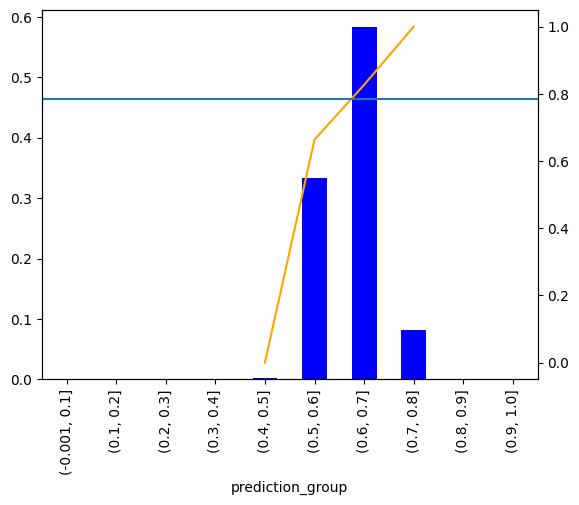

              precision    recall  f1-score   support

           0       0.22      1.00      0.35        77
           1       0.00      0.00      0.00       280

    accuracy                           0.22       357
   macro avg       0.11      0.50      0.18       357
weighted avg       0.05      0.22      0.08       357

AUC Score: 0.7164888682745826


C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [37]:
present_scores(y_test, y_pred_proba, n_bins=10)

# Compute confusion matrix

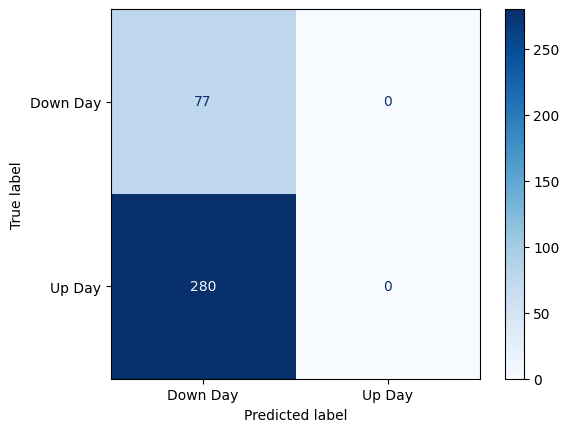

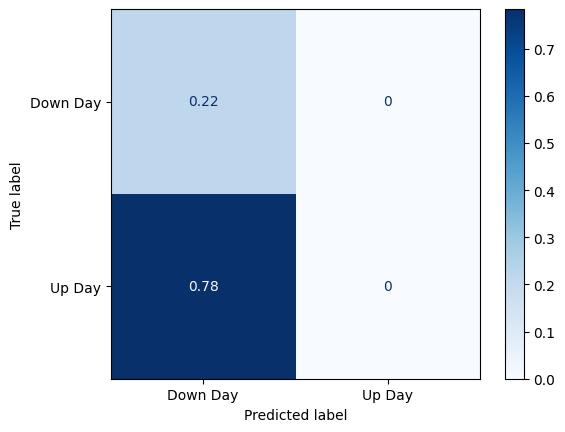

In [38]:
# Compute confusion matrix to evaluate the accuracy of the classification - displaying actual total values numbers per category

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Compute confusion matrix to evaluate the accuracy of the classification - displaying normalized values numbers

cm = confusion_matrix(y_test, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()



In [39]:

# הבר (המקל) הכחול מתאר כמה תצפיות יש בכל בין של הסתברות, למשל, בבין של 0.3 עד 0.4 יש 38% מהתצפיות
# הקו הכחול לעומתו, מתאר את המציאות - כמה ״1״-ים יש לנו במציאות
# הקו הכתום, תמיד צריך להיות משווה לקו הכחול, מעיד על אחוז הדיוק בבין
# נשים את הסף כל עוד הקו הכתום מעל הקו הכחול, או במינימום בנק׳ המפגש שלהם
# במודל טוב - ככל שההתסברות גבוהה יותר, כך הוא גם צודק יותר, ולכן בגדול הקו הכתום צריך לעלות, אבל זה לא המצב אצלנו

In [39]:
#create the profit function - based on the percentage of change in the "market cap percentage" column

# create prediction column in the "test" dataframe based on the model results, set it to binary number instead of True / False

test['prediction'] = y_pred.astype(int)
# test = test.reset_index()
test['profit_percentage'] = test['diff_in_mc_perc'] * test['prediction']
profit_perc_sum = round(test['profit_percentage'].sum(), 3)
profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)

print("The total profit in percentage after investing in APH stock is:",profit_perc_mean,"%")

The total profit in percentage after investing in APH stock is: nan %


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_20752\3225782778.py:9: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)
